## 기본설정 및 전처리

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as offline
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
import geopandas as gpd
from geopandas import GeoSeries
import pyproj
from tqdm import tqdm
#from keplergl import KeplerGl

# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)

In [2]:
# Polygon을 만드는 함수
def make_pol(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])

In [3]:
# Linestring을 만드는 함수
def make_lin(x):
    try:
        return LineString(x)
    except:
        return LineString(x[0])

In [4]:
# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # 위도 및 경도롤 GeoPandas Point 객체로 변환
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

### 청주시_도시재생계획구역

In [5]:
# GeoJSON 파일 불러오기
with open('SBJ_2309_001/27.청주시_도시재생계획구역.geojson', encoding='utf-8') as geojson_file:
    geojson_data = json.load(geojson_file)
crp_df = pd.json_normalize(geojson_data) # city_revitalize_planning_map_df
crp_df['geometry'] = crp_df['geometry.coordinates'].apply(lambda x : make_pol(x))
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)

# 폴리곤의 중점을 찾음
centroid = crp_df['geometry'].iloc[0].centroid.buffer(0.015) # 1도의 위도 변화는 대략 111.32 킬로미터
crp_df['centroid_polygon_geometry'] = [centroid]
crp_df

,type,properties.fid,properties.구역명,geometry.type,geometry.coordinates,geometry,centroid_polygon_geometry
0,Feature,5,도시재생구역도,Polygon,"[[[127.4833417, 36.6318644], [127.4833417, 36....","POLYGON ((127.4833417 36.6318644, 127.4833417 ...",POLYGON ((127.50347965416363 36.63603755594320...


### 격자(매핑용)

In [6]:
# GeoJSON 파일 불러오기
with open('SBJ_2309_001/26.청주시_격자(매핑용).geojson') as geojson_file:
    geojson_data = json.load(geojson_file)
grid_map_df = pd.json_normalize(geojson_data['features'])
grid_map_df['geometry'] = grid_map_df['geometry.coordinates'].apply(lambda x : make_pol(x))

In [7]:
# crp_df에서 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
polygon_expanded = crp_df['centroid_polygon_geometry'].iloc[0]

# grid_map_df 데이터프레임을 GeoDataFrame으로 변환
grid_map_df = gpd.GeoDataFrame(grid_map_df, geometry='geometry')
#grid_map_df['geometry'] = GeoSeries(grid_map_df['geometry'])

# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_grid = grid_map_df[grid_map_df['geometry'].intersects(polygon)].reset_index(drop=True) # polygon과 교차하거나 포함하는 경우를 모두 선택, within 은 포함
# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_grid_expanded = grid_map_df[grid_map_df['geometry'].intersects(polygon_expanded)].reset_index(drop=True) # polygon과 교차하거나 포함하는 경우를 모두 선택

#### 청주시 상세 도로망 & 도로명주소 데이터 필터링 및 통합

In [8]:
# GeoJSON 파일 불러오기
with open('SBJ_2309_001/13.청주시_상세도로망.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
roadsystem_df = pd.json_normalize(geojson_data['features'])
roadsystem_df['geometry'] = roadsystem_df['geometry.coordinates'].apply(lambda x : LineString(x))
roadsystem_df['properties.link_id'] = roadsystem_df['properties.link_id'].astype(str)
# roadsystem_df 데이터프레임을 GeoDataFrame으로 변환
roadsystem_df = gpd.GeoDataFrame(roadsystem_df, geometry='geometry')
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_roadsystem = roadsystem_df[roadsystem_df['geometry'].intersects(polygon)].reset_index(drop=True)

# GeoJSON 파일 불러오기
with open('SBJ_2309_001/16.청주시_도로명주소(도로).geojson', 'r') as geojson_file:
    geojson_data = json.load(geojson_file)
roadname_road_df = pd.json_normalize(geojson_data['features'])
roadname_road_df['geometry'] = roadname_road_df['geometry.coordinates'].apply(lambda x: LineString(x))
# roadsystem_df 데이터프레임을 GeoDataFrame으로 변환
roadname_road_df = gpd.GeoDataFrame(roadname_road_df, geometry='geometry')
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_roadname_road = roadname_road_df[roadname_road_df['geometry'].within(polygon)].reset_index(drop=True)

# 통합 도로망 df
tot_roadsystem = pd.concat([filtered_roadsystem[['geometry']], filtered_roadname_road[['geometry']]])

#### 청주시 시장현황 필터링

In [ ]:
# 시장 데이터프레임을 GeoPandas 데이터프레임으로 변환
market_df = pd.read_csv('SBJ_2309_001/6.청주시_시장현황.csv')
market_df = geo_transform(market_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# market_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_market = market_df[market_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 주차장 현황

In [ ]:
# 시장 데이터프레임을 GeoPandas 데이터프레임으로 변환
parking_df = pd.read_csv('SBJ_2309_001/7.청주시_주차장현황.csv')
parking_df = geo_transform(parking_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0].centroid.buffer(0.01)
# parking_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_parking = parking_df[parking_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 공공기관 및 주요지점 현황

In [ ]:
public_df = pd.read_csv('SBJ_2309_001/25.청주시_공공기관_및_주요지점현황.csv')
# 데이터프레임을 GeoPandas 데이터프레임으로 변환
public_df = geo_transform(public_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# public_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_public = public_df[public_df['geometry'].within(polygon)]
filtered_points_public['inst_gbn'] = filtered_points_public['inst_gbn'].replace('공공기관', '행정기관')
filtered_points_public['inst_gbn'] = filtered_points_public['inst_gbn'].replace('시군청', '행정기관')
filtered_points_public['inst_gbn'] = filtered_points_public['inst_gbn'].replace('도단위기관', '행정기관')
filtered_points_public['inst_gbn'] = filtered_points_public['inst_gbn'].replace('민간기관', '상업시설')
filtered_points_public = filtered_points_public.drop_duplicates(subset='geometry', keep='first').reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

#### 청주시 공원 현황

In [ ]:
# 시장 데이터프레임을 GeoPandas 데이터프레임으로 변환
park_df = pd.read_csv('SBJ_2309_001/8.청주시_공원현황.csv')
park_df = geo_transform(park_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# park_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_park = park_df[park_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 인도(보도) 시각화

In [ ]:
# GeoJSON 파일 불러오기
with open('SBJ_2309_001/17.청주시_인도(보도).geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
sidewalk_df = pd.json_normalize(geojson_data['features'])
sidewalk_df['geometry'] = sidewalk_df['geometry.coordinates'].apply(make_lin)
# roadsystem_df 데이터프레임을 GeoDataFrame으로 변환
sidewalk_df = gpd.GeoDataFrame(sidewalk_df, geometry='geometry')
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_sidewalk = sidewalk_df[sidewalk_df['geometry'].intersects(polygon)].reset_index(drop=True)

#### 청주시 폐공장현황

In [ ]:
# 데이터프레임 로드 및 GeoPandas 데이터프레임으로 변환
factory_df = pd.read_csv('SBJ_2309_001/9.청주시_폐공장현황.csv')
factory_df = geo_transform(factory_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]

# 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_factory = factory_df[factory_df['geometry'].within(polygon)]

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 문화재 현황

In [ ]:
# 데이터프레임 로드 및 GeoPandas 데이터프레임으로 변환
culture_assets_df = pd.read_csv('SBJ_2309_001/5.청주시_유적지_문화재현황.csv')
culture_assets_df = geo_transform(culture_assets_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]

# 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_culture = culture_assets_df[culture_assets_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 학교 현황

In [ ]:
# 데이터프레임 로드 및 GeoPandas 데이터프레임 변환
school_df = pd.read_csv('SBJ_2309_001/24.청주시_학교현황.csv')
school_df = geo_transform(school_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0] # 또는 centroid_polygon_geometry
# 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_school = school_df[school_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


#### 청주시 어린이집 유치원 현황

In [ ]:
# 데이터프레임 로드 및 GeoPandas 데이터프레임으로 변환
kinder_df = pd.read_csv('SBJ_2309_001/28.청주시_어린이집_유치원현황.csv')
kinder_df = geo_transform(kinder_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0] # 또는 centroid_polygon_geometry
# 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_kinder = kinder_df[kinder_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


#### 청주시 상권정보 

In [ ]:
# 상권정보 데이터 로드 및 GeoDataFrame으로 변환
trading_area_df = pd.read_csv('SBJ_2309_001/18.청주시_상권정보.csv')
trading_area_df = geo_transform(trading_area_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_trading_area = trading_area_df[trading_area_df['geometry'].within(polygon)].reset_index(drop=True)

#### 청주시 가로수 현황 (공공데이터포털 - 산림청_도시숲가로수관리 가로수 현황 https://www.data.go.kr/data/15120900/fileData.do)

In [ ]:
'''산림청_도시숲가로수관리 가로수 현황_20221231 데이터 정제 완료 -'''
# street_tree_df = pd.read_csv('SBJ_2309_001/산림청_도시숲가로수관리 가로수 현황_20221231.csv', encoding='cp949')
# street_tree_df = street_tree_df[['시군구명', '도로구간명', '수종명', '지역X좌표', '지역Y좌표']]
# street_tree_df = street_tree_df[street_tree_df['시군구명'].str.contains('청주')].reset_index(drop=True)

# # EPSG 5186에서 EPSG 4326으로 좌표 변환을 수행하는 함수 생성
# def transform_coordinates(row):
#     in_proj = pyproj.Proj(init='epsg:5186')
#     out_proj = pyproj.Proj(init='epsg:4326')
#     lon, lat = pyproj.transform(in_proj, out_proj, row['지역X좌표'], row['지역Y좌표'])
#     return pd.Series({'lat': lat, 'lon': lon})

# # '지역X좌표'와 '지역Y좌표'를 EPSG 4326으로 변환하고 'lat' 및 'lon' 열로 이름 변경
# street_tree_df[['lat', 'lon']] = street_tree_df.apply(transform_coordinates, axis=1)
# # '지역X좌표'와 '지역Y좌표' 열을 삭제 (선택 사항)
# street_tree_df.drop(['지역X좌표', '지역Y좌표'], axis=1, inplace=True)

# 가로수 데이터프레임 로드 및 GeoPandas 변환
street_tree_df = pd.read_csv('SBJ_2309_001/29.청주시_가로수현황.csv', encoding='UTF8')
street_tree_df = geo_transform(street_tree_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0] # 또는 centroid_polygon_geometry

# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_tree = street_tree_df[street_tree_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



## 청주시 성연령별 유동인구

In [14]:
# 원도심 영역(도시재생 대상지역)
floating_population_df = pd.read_csv('SBJ_2309_001/2.청주시_성연령별_유동인구.csv')
floating_population_df['STD_YM'] = floating_population_df['STD_YM'].astype(str)
floating_population_df.rename(columns={'STD_YM':'연도'}, inplace=True)
# 데이터프레임을 GeoPandas 데이터프레임으로 변환
floating_population_df = geo_transform(floating_population_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# floating_population_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_floating_population = floating_population_df[floating_population_df['geometry'].within(polygon)]

# 성별 통합한 세대 column 생성
filtered_floating_population['MZ'] = filtered_floating_population.iloc[:, 1:4].sum(axis=1).copy() + filtered_floating_population.iloc[:, 7:10].sum(axis=1).copy()
filtered_floating_population['N_MZ'] = filtered_floating_population.iloc[:, 4:7].sum(axis=1).copy() + filtered_floating_population.iloc[:, 10:13].sum(axis=1).copy()

# 특정 열만 추출하여 성별을 통합한 세대별 유동인구 df생성
filtered_floating_population_gen = filtered_floating_population[list(filtered_floating_population.columns[:1]) + list(filtered_floating_population.columns[16:18]) + [filtered_floating_population.columns[15]]]

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\HJK\anaconda3\envs\GIS\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [15]:
# 최종저장용 df 정의 -> 각 지점들을 grid폴리곤에 매핑시켜 grid별 유동인구로 변환 -> 
filtered_floating_population_totgen = pd.DataFrame()
for grid in tqdm(filtered_grid['geometry'].unique()):
    # 격자와 매핑하기 위해 격자 내에 있는 지점으로만 필터링
    subset = filtered_floating_population_gen[filtered_floating_population_gen['geometry'].within(grid)]
    # 해당 구역 grid df 설정(접합용) 
    grid_df = pd.DataFrame({'geometry' : [grid]})
    # 중간저장용 df 정의
    concat_df = pd.DataFrame()
    
    for date in filtered_floating_population_gen['연도'].unique():
        date_df = pd.DataFrame({'연도' : [date[:4]]}) # 해당 연도 df 설정(접합용) 
        subset_date = subset[subset['연도'] == date]
        # 열 별로 더하기 및 df 변환
        column_sums = subset_date.iloc[:,1:3].sum()
        column_sums_df = pd.DataFrame(column_sums).transpose()
        # 최종 df 접합 및 filtered_floating_population_totgen에 concat
        column_sums_df = pd.concat([date_df, column_sums_df], axis=1)
        concat_df = pd.concat([concat_df, column_sums_df])
    else:
        # 각 연도 별로 평균계산 및 df 변환 -> 월별 유동인구를 평균내었기 때문에, 최종값은 해당 격자의 월별 평균 유동인구가 됨.
        column_means_2020 = concat_df[concat_df['연도'].str.startswith('2020')].iloc[:,1:3].mean()
        date_df_2020 = pd.DataFrame({'연도' : ['2020']})
        column_means_2020_df = pd.DataFrame(column_means_2020).transpose()
        tot_df_2020 = pd.concat([date_df_2020, column_means_2020_df, grid_df], axis=1)
        
        column_means_2021 = concat_df[concat_df['연도'].str.startswith('2021')].iloc[:,1:3].mean()
        date_df_2021 = pd.DataFrame({'연도' : ['2021']})
        column_means_2021_df = pd.DataFrame(column_means_2021).transpose()
        tot_df_2021 = pd.concat([date_df_2021, column_means_2021_df, grid_df], axis=1)
        
        column_means_2022 = concat_df[concat_df['연도'].str.startswith('2022')].iloc[:,1:3].mean()
        date_df_2022 = pd.DataFrame({'연도' : ['2022']})
        column_means_2022_df = pd.DataFrame(column_means_2022).transpose()
        tot_df_2022 = pd.concat([date_df_2022, column_means_2022_df, grid_df], axis=1)
        
        tot_df = pd.concat([tot_df_2020, tot_df_2021, tot_df_2022])
        filtered_floating_population_totgen = pd.concat([filtered_floating_population_totgen, tot_df])

filtered_floating_population_totgen

100%|██████████| 156/156 [00:18<00:00,  8.50it/s]


,연도,MZ,N_MZ,geometry
0,2020,31.897500,79.245000,"POLYGON ((127.4921705012675 36.62987958832503,..."
0,2021,23.554167,63.031667,"POLYGON ((127.4921705012675 36.62987958832503,..."
0,2022,26.054167,77.063333,"POLYGON ((127.4921705012675 36.62987958832503,..."
0,2020,588.386667,1078.526667,POLYGON ((127.48881291670402 36.64430329023720...
0,2021,730.630833,1277.312500,POLYGON ((127.48881291670402 36.64430329023720...
...,...,...,...,...
0,2021,50.055000,87.478333,POLYGON ((127.49105137605241 36.63528850233756...
0,2022,63.792500,119.714167,POLYGON ((127.49105137605241 36.63528850233756...
0,2020,16.146667,30.440833,POLYGON ((127.48433936092893 36.63799230366292...
0,2021,13.730833,25.674167,POLYGON ((127.48433936092893 36.63799230366292...


#### 유동인구 HEATMAP 비교(MZ세대 & 비MZ세대)


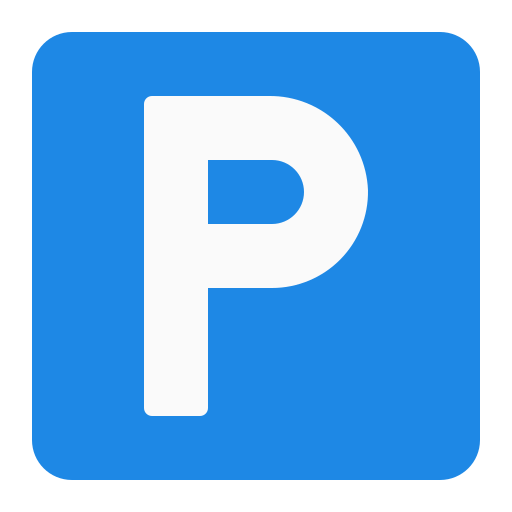
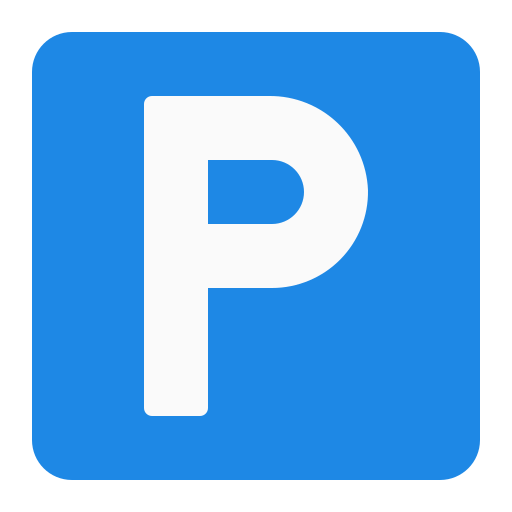
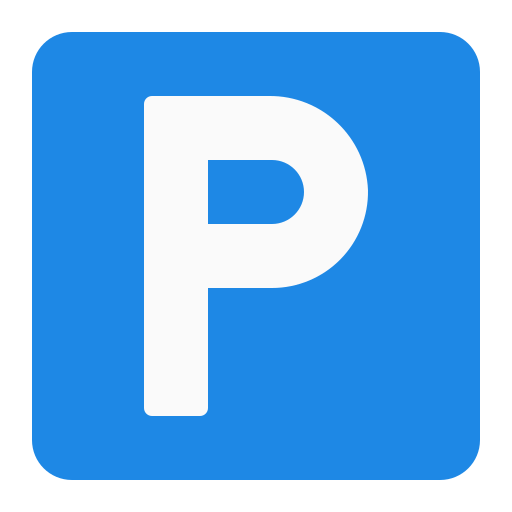
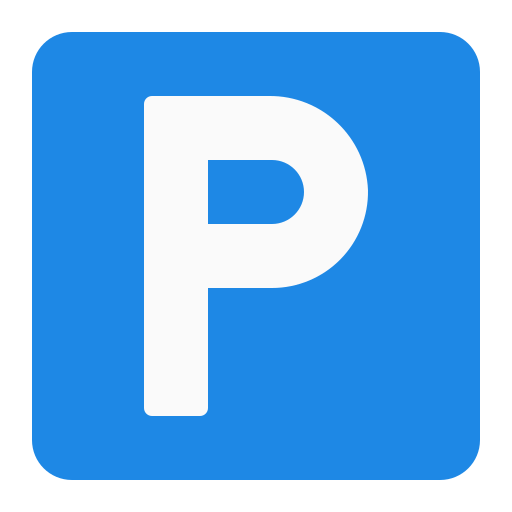
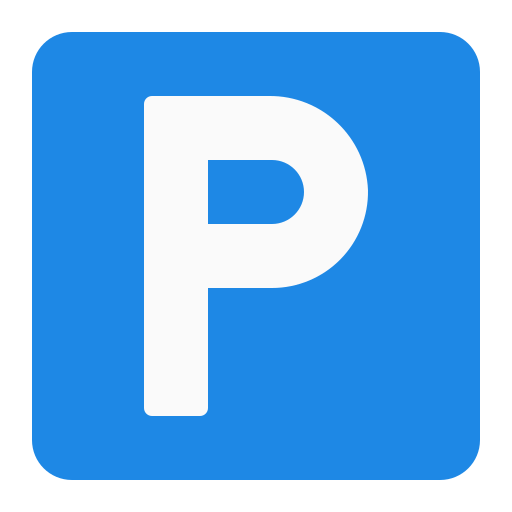
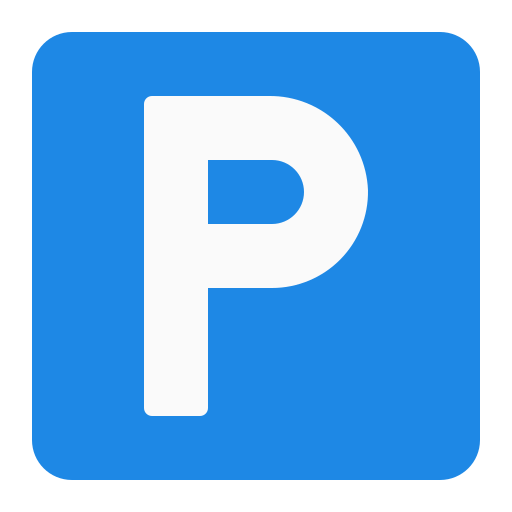
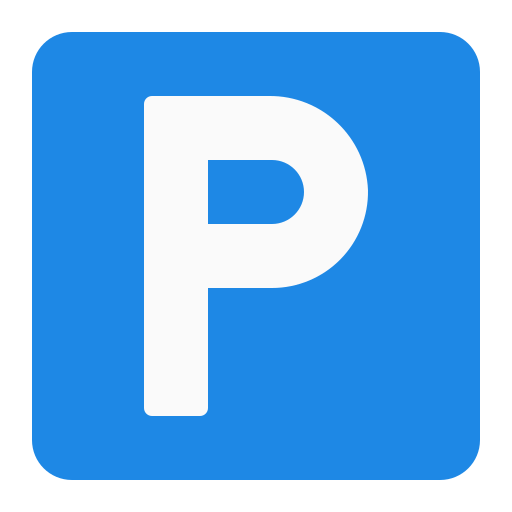
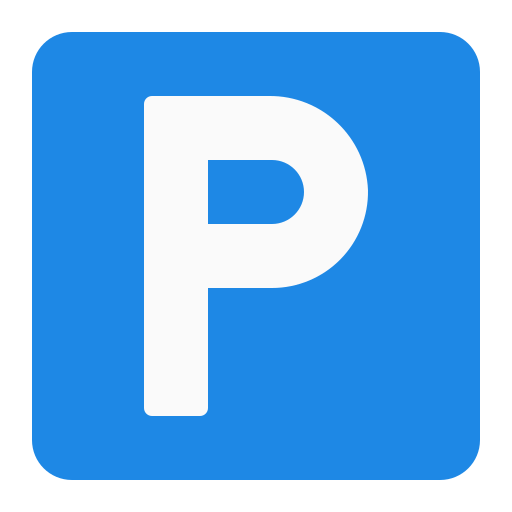
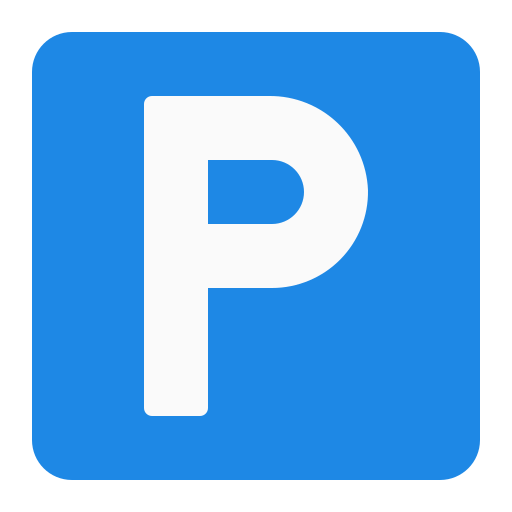
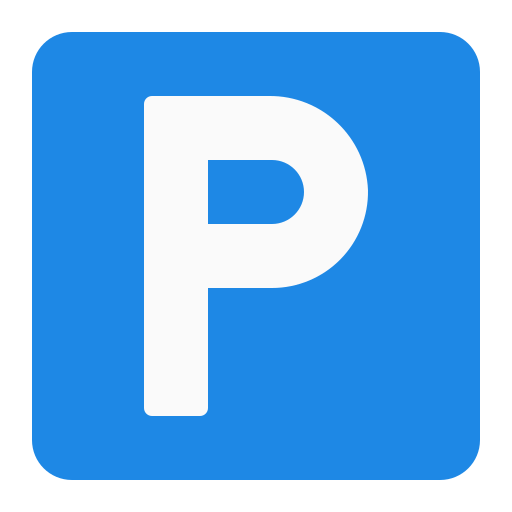
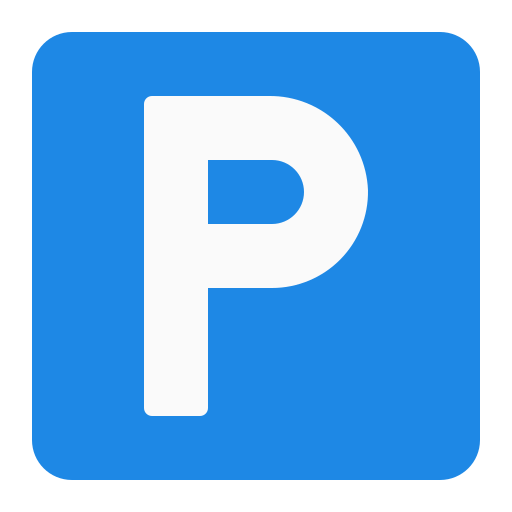
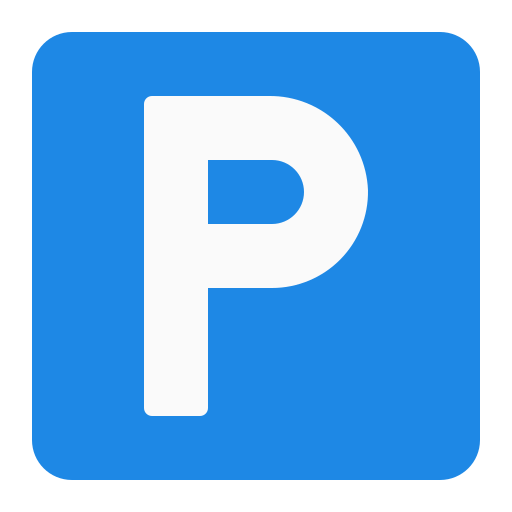
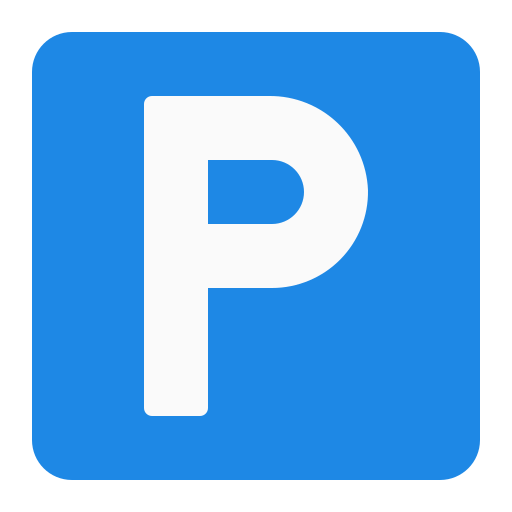
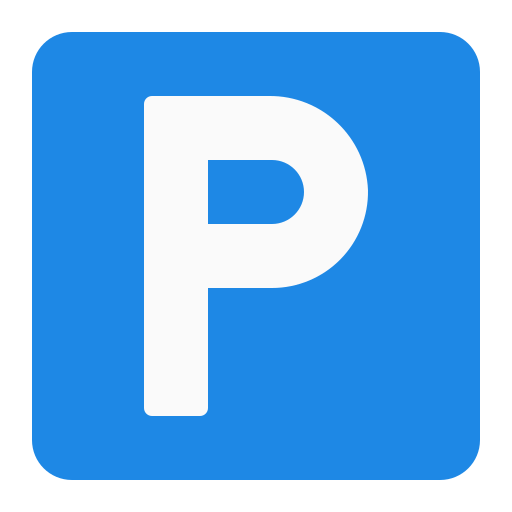
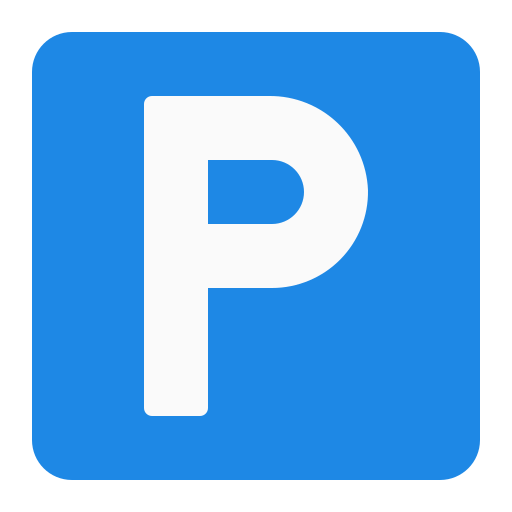
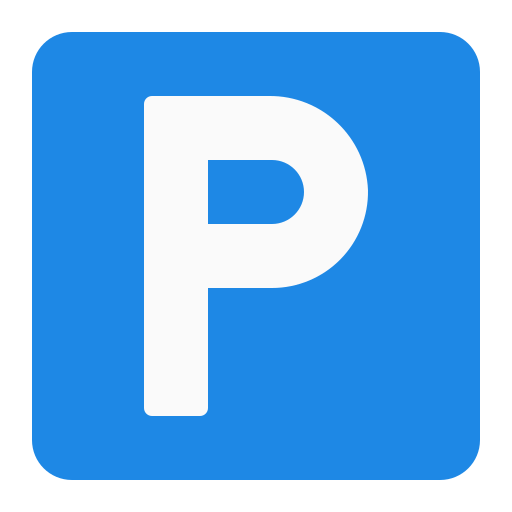
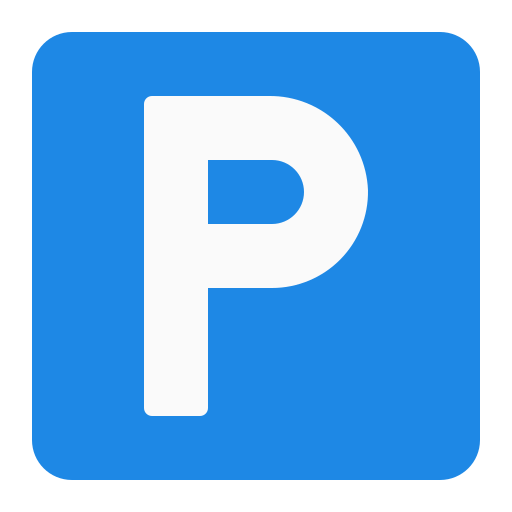
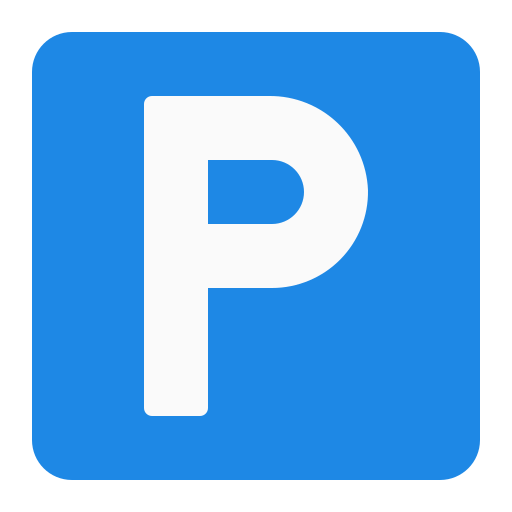
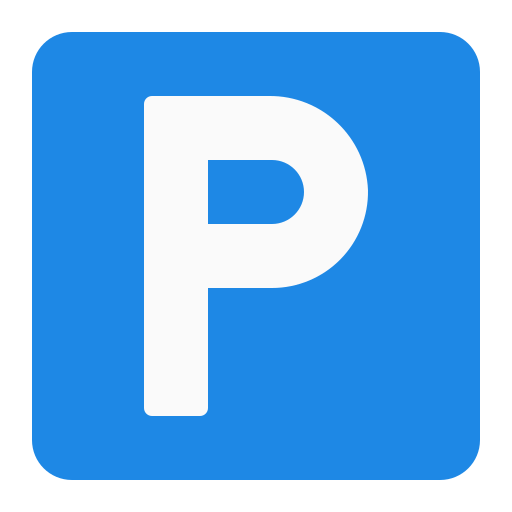
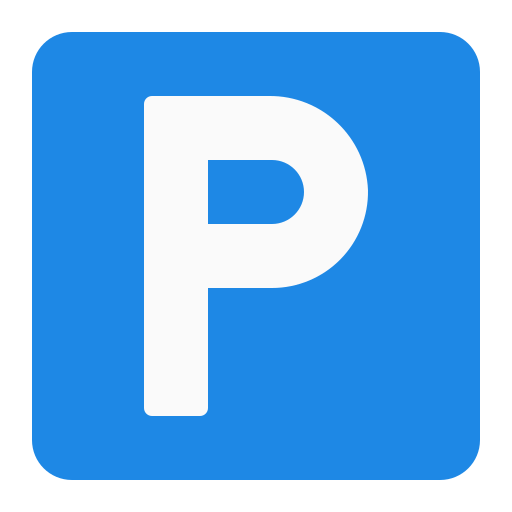
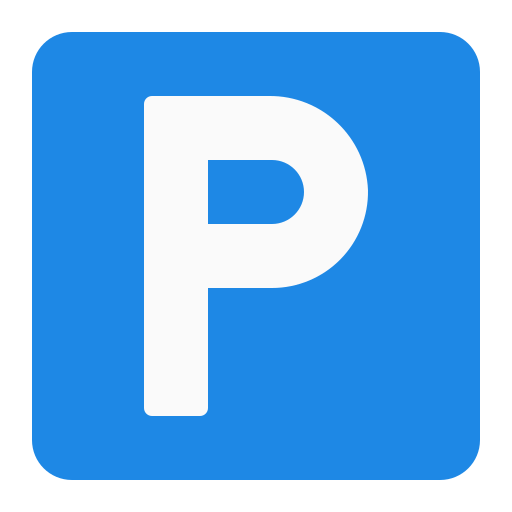
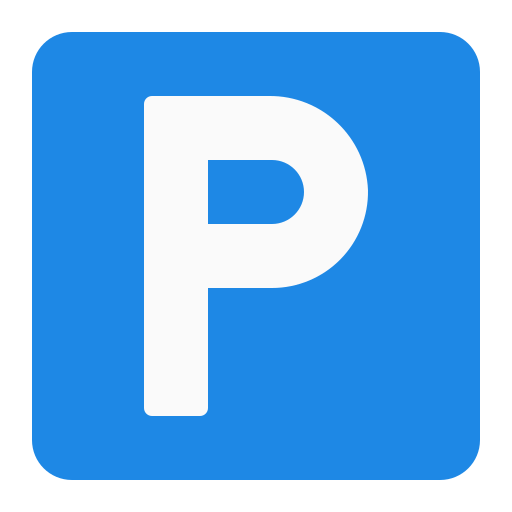
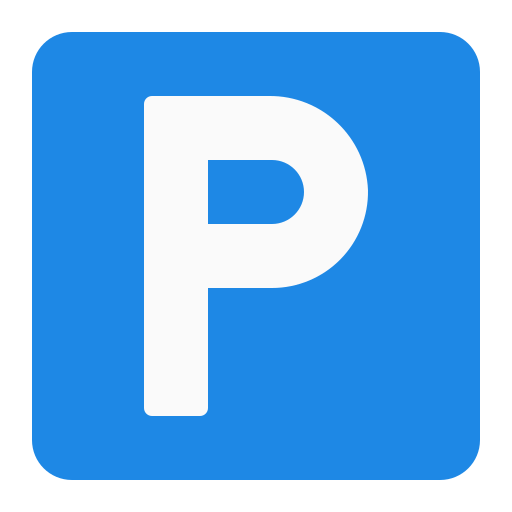
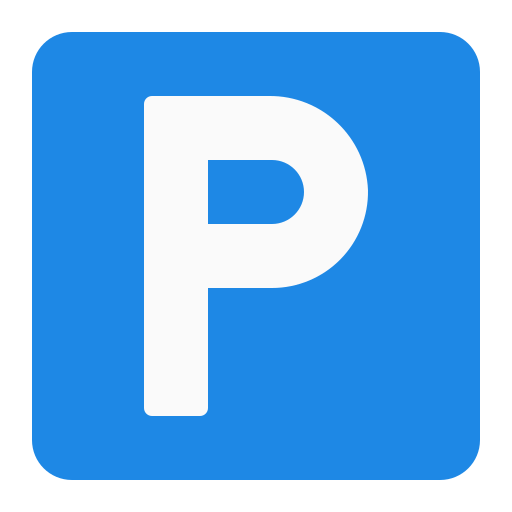
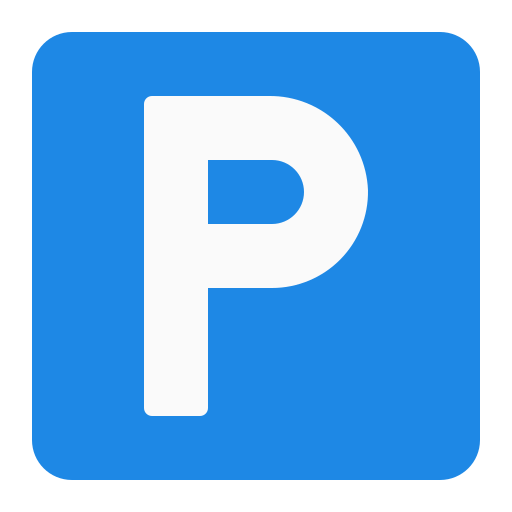
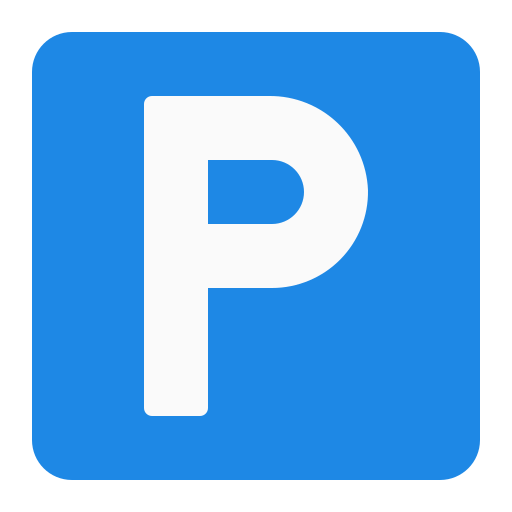
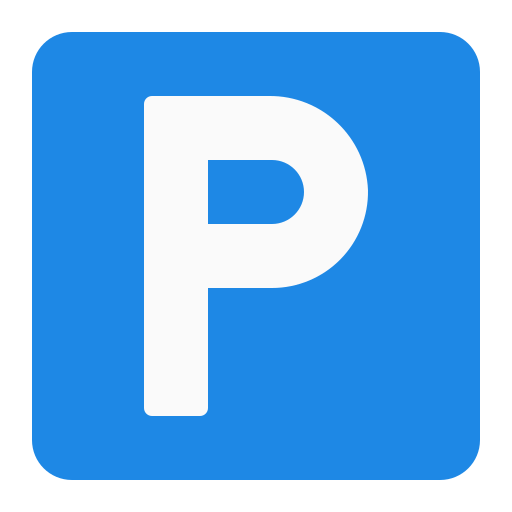
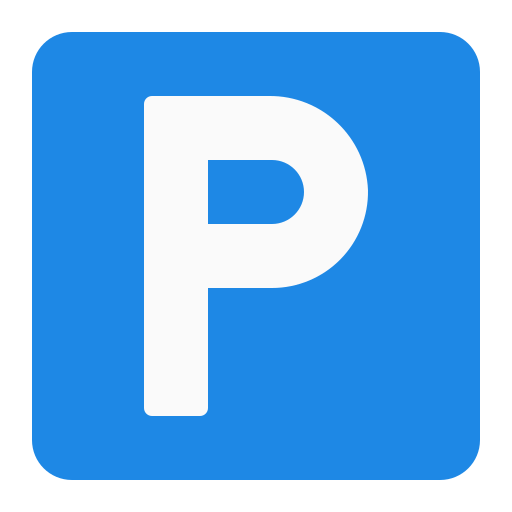
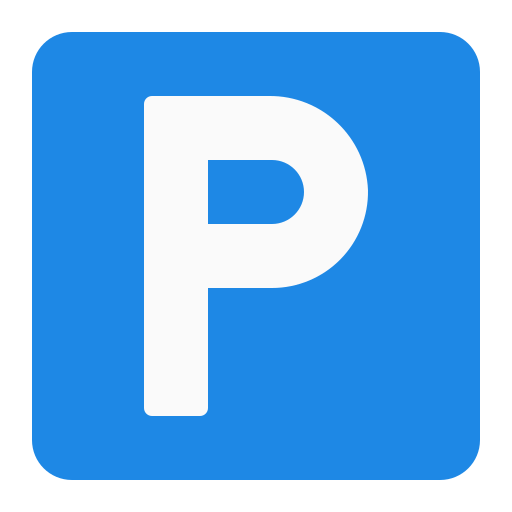
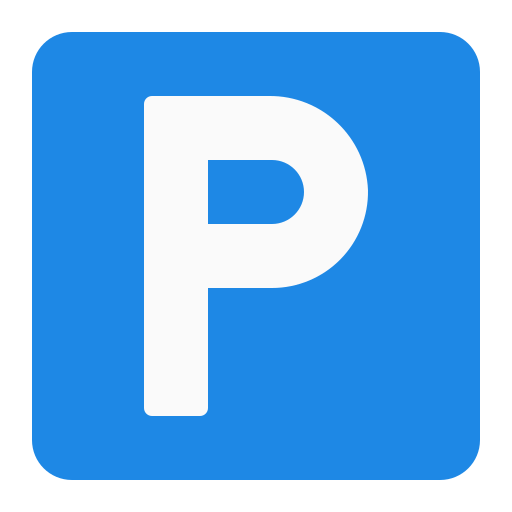
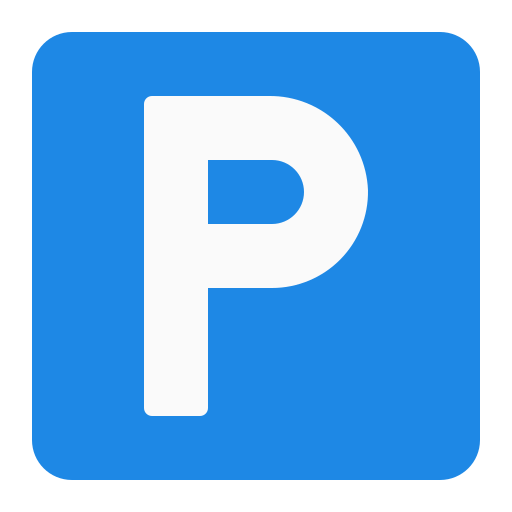
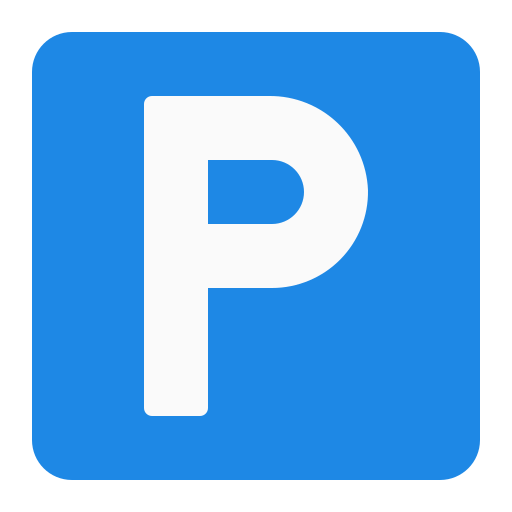
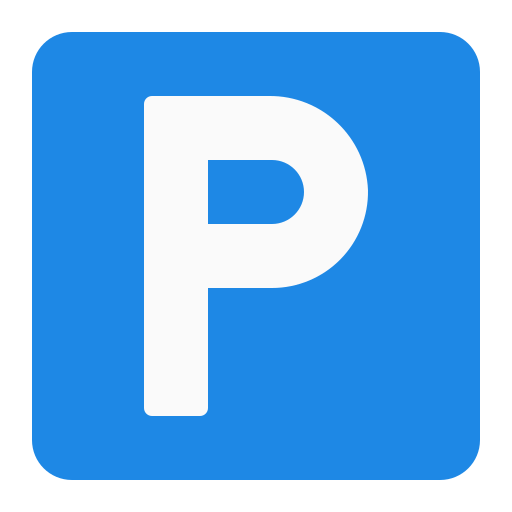
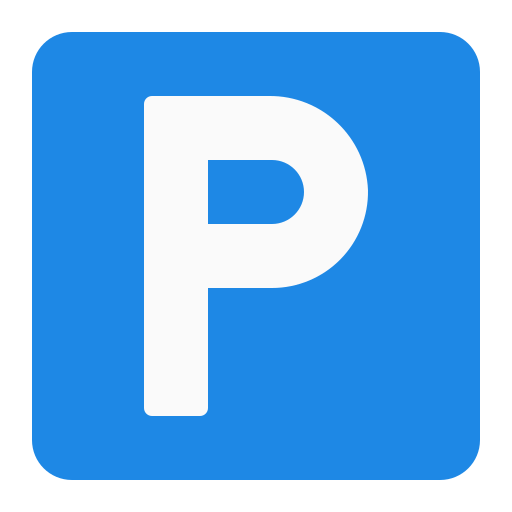
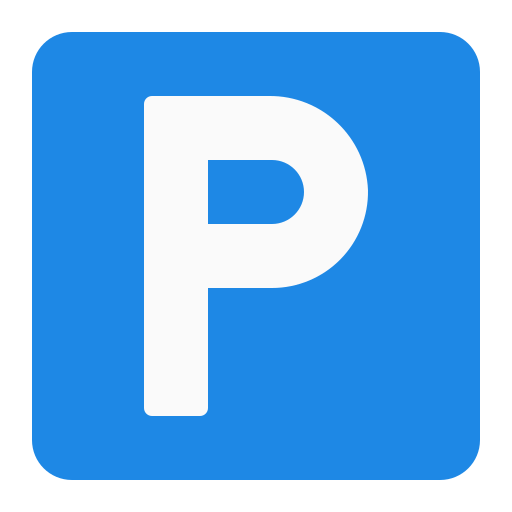
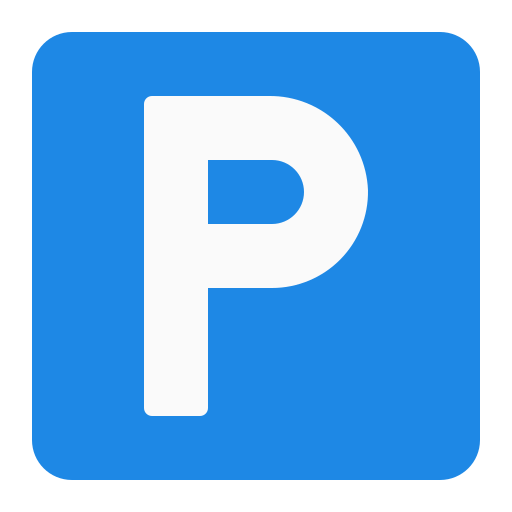
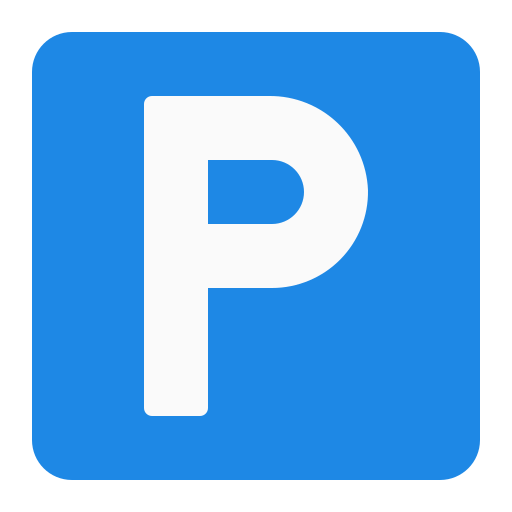
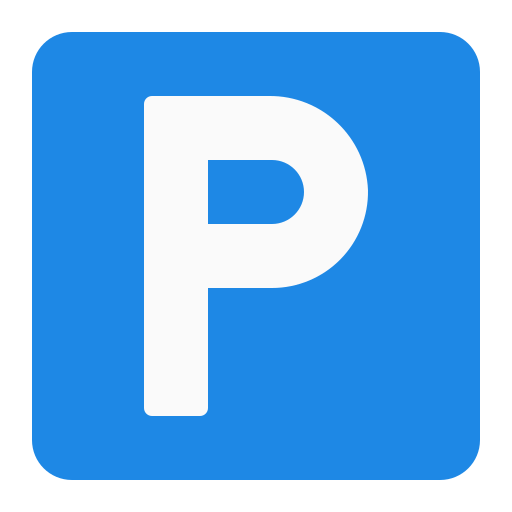
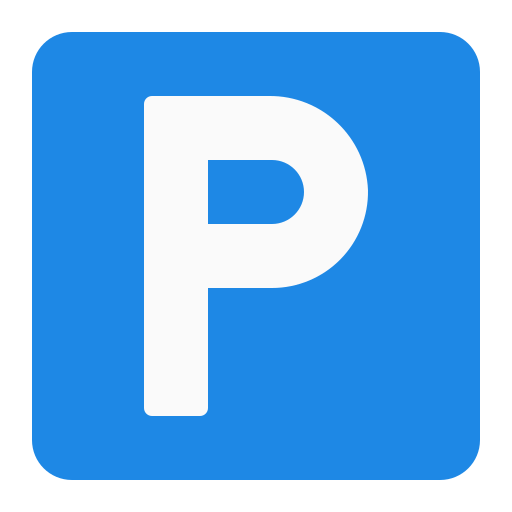
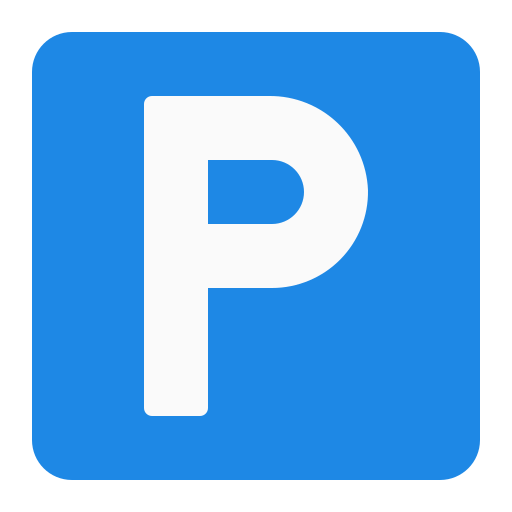
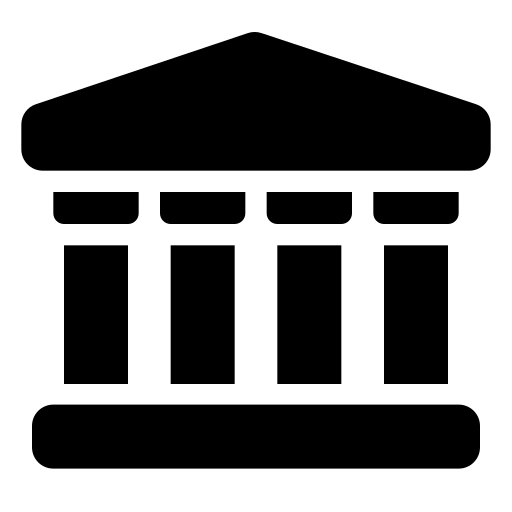
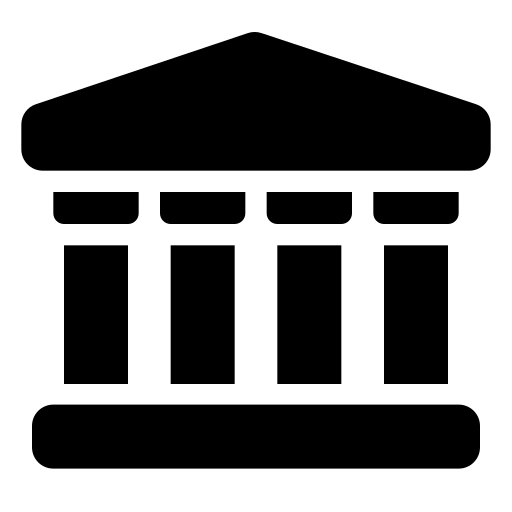
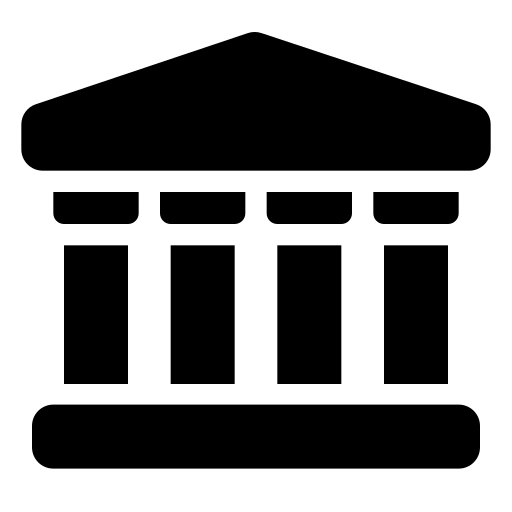
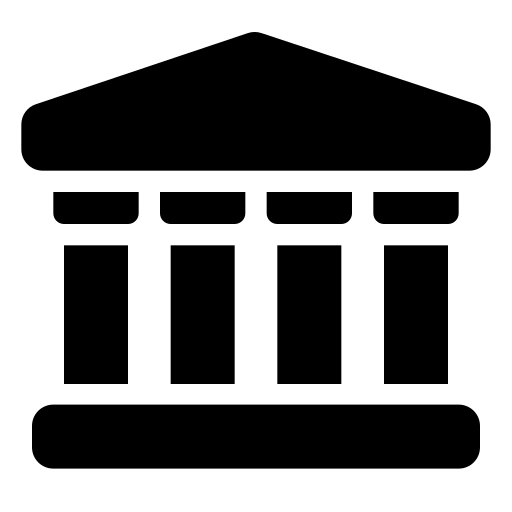
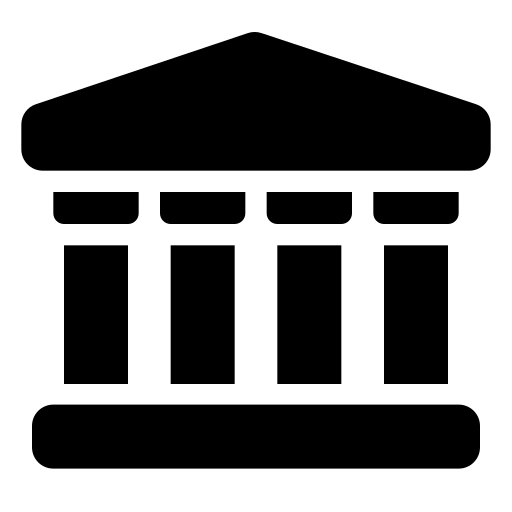
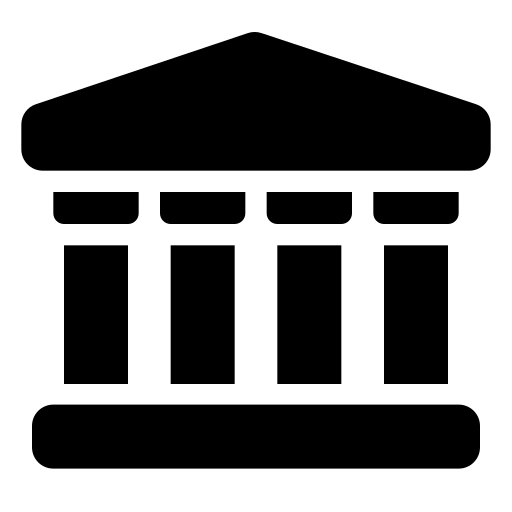
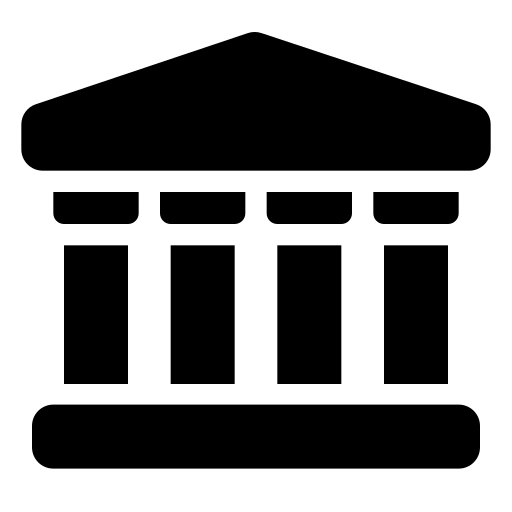
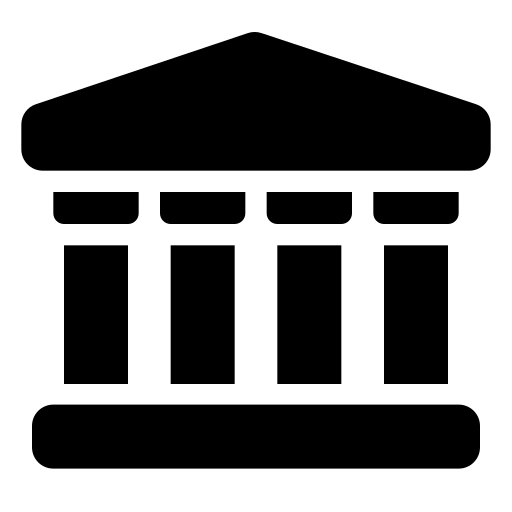
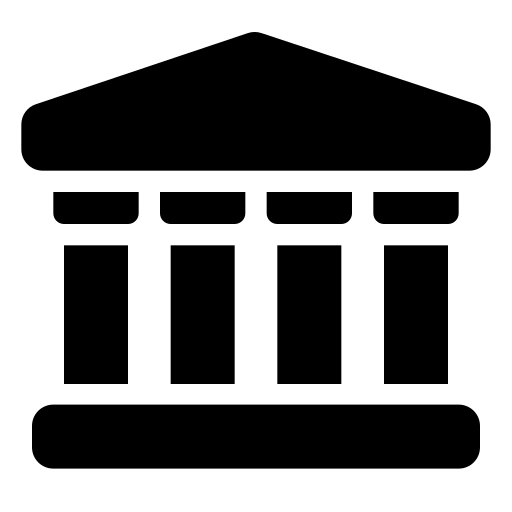
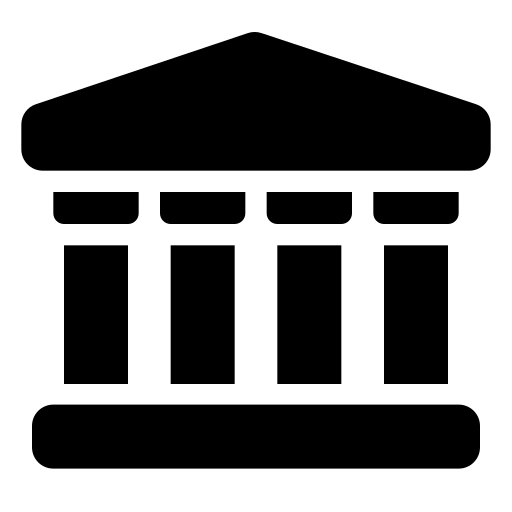
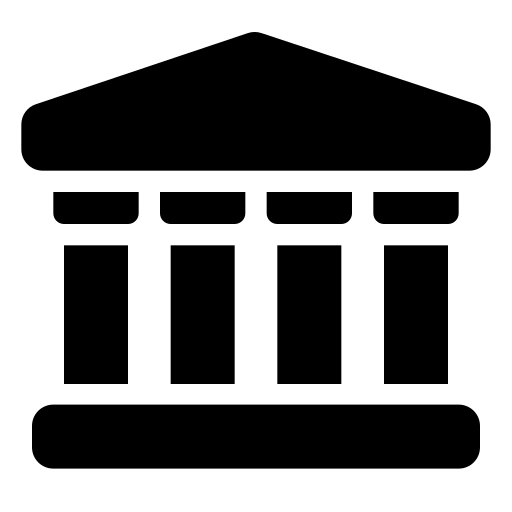
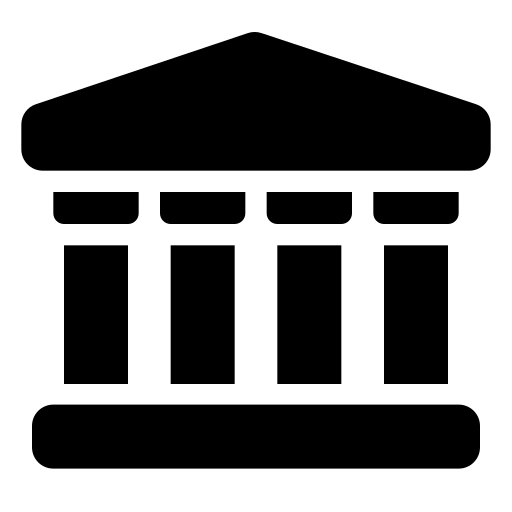
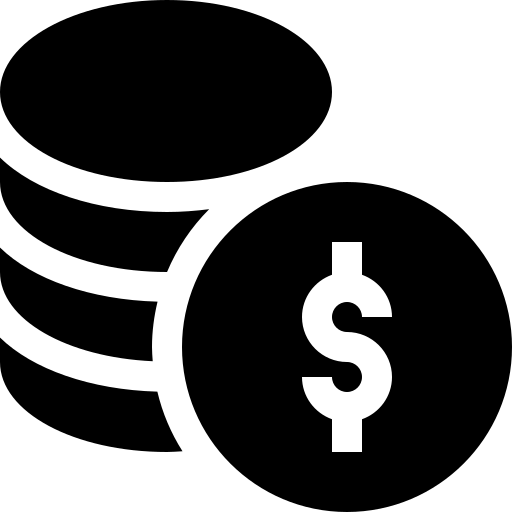
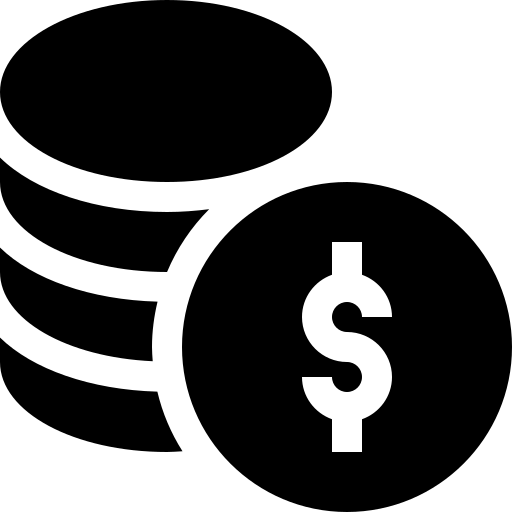
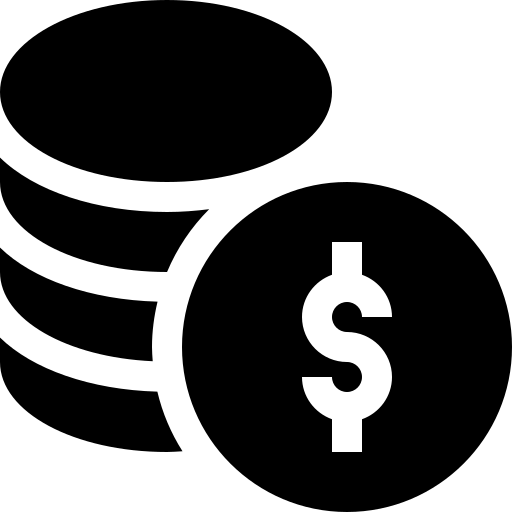
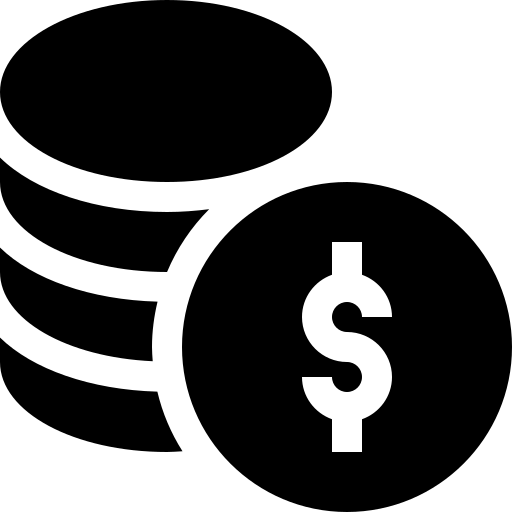
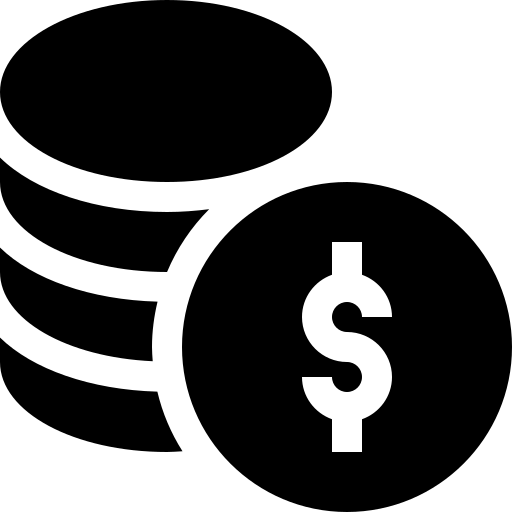
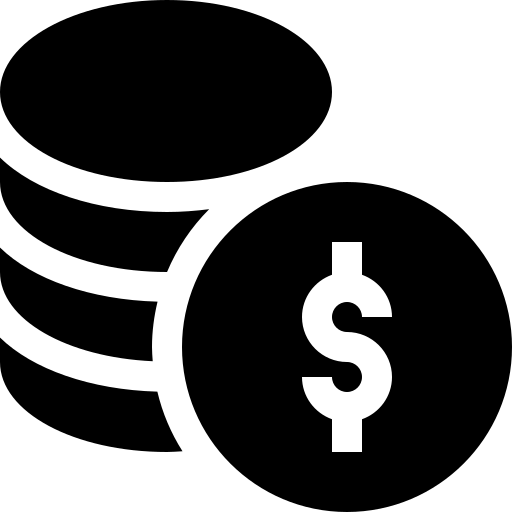
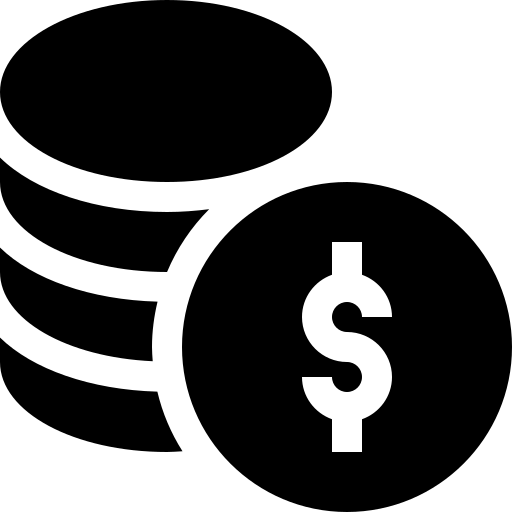
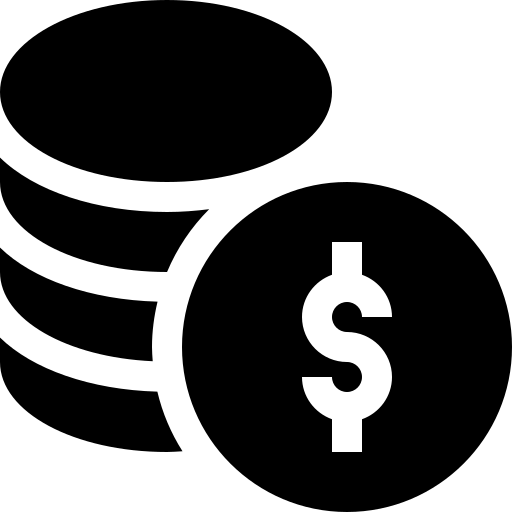
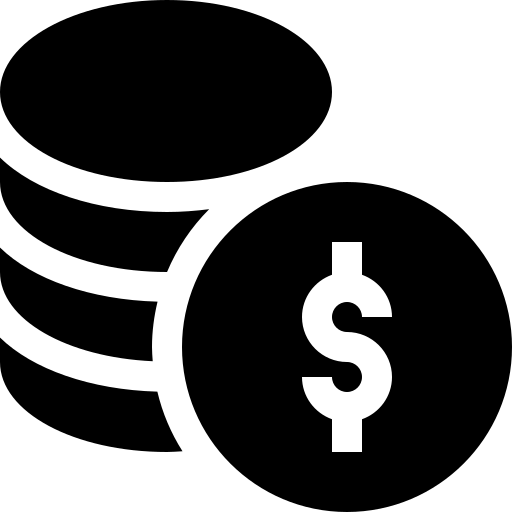
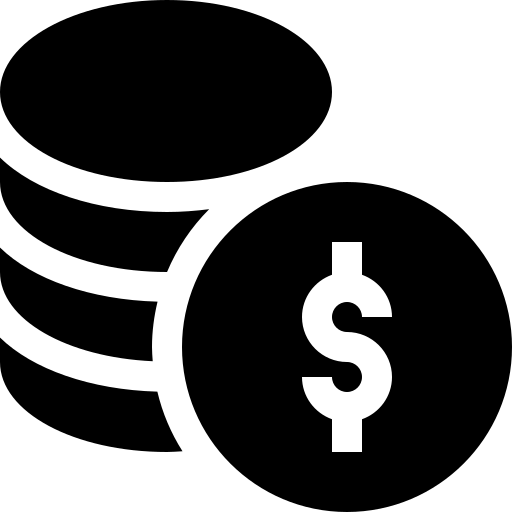
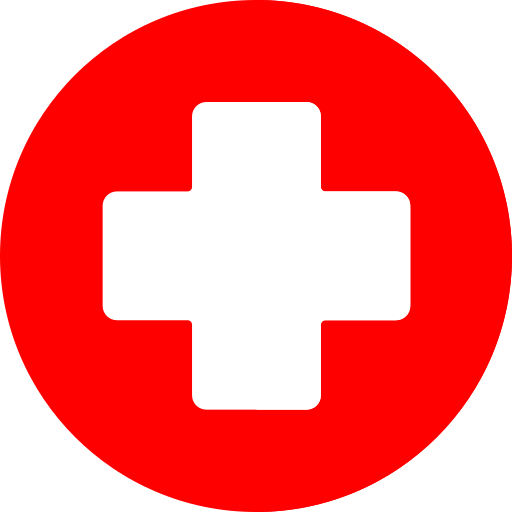
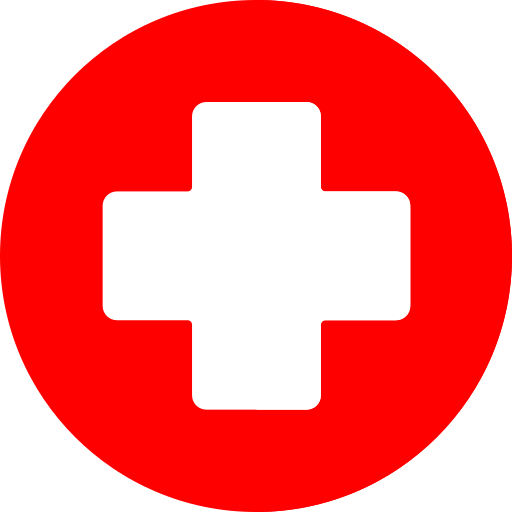
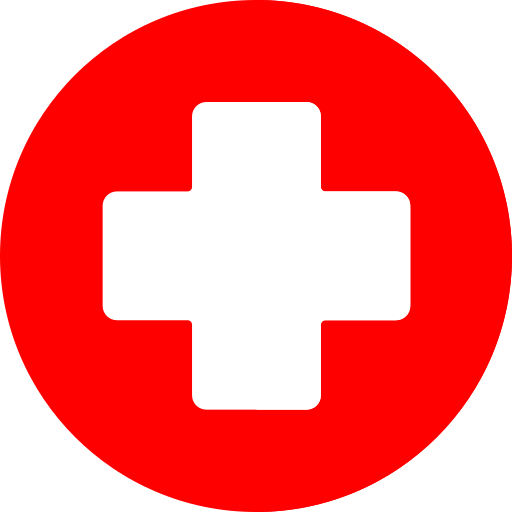
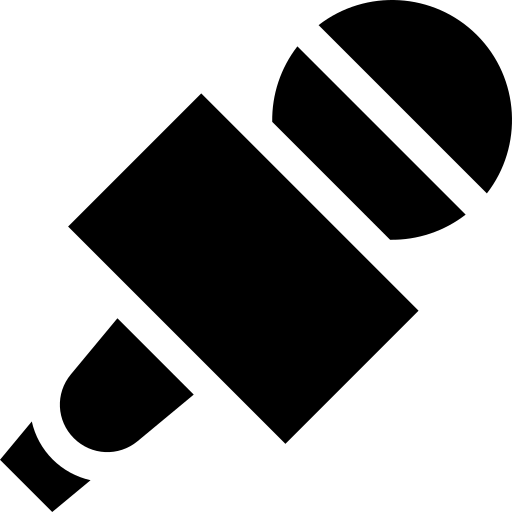
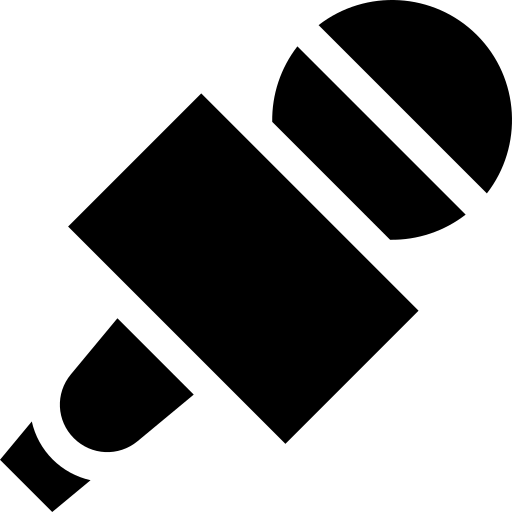
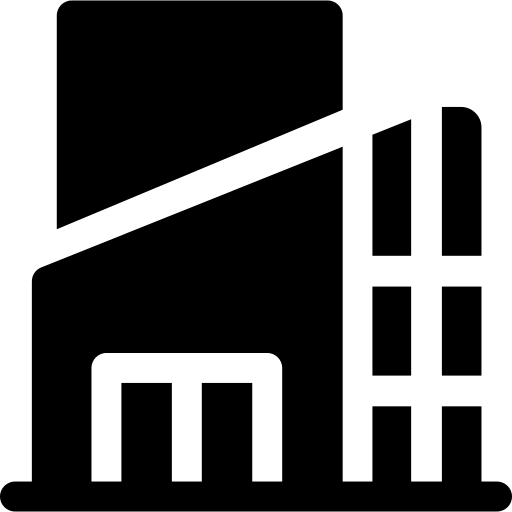
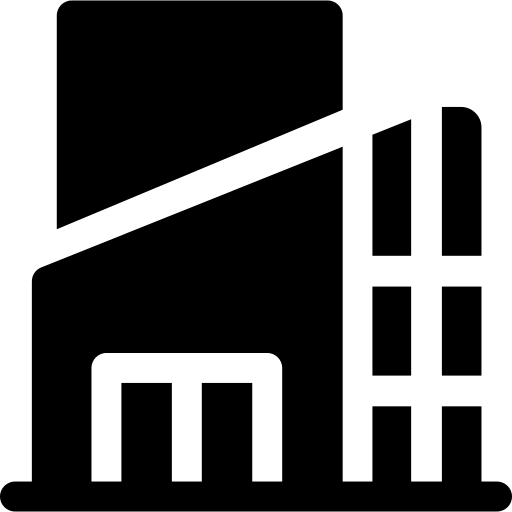
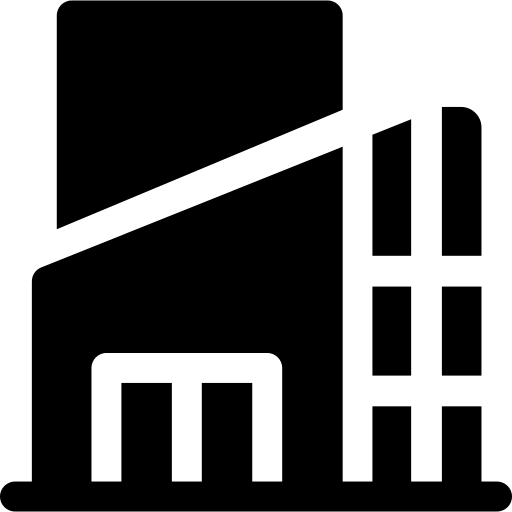

In [23]:
# map 생성
m = folium.Map(location=[36.627797, 127.511943], zoom_start=14)

# 기본 배경지도를 항상 표시하도록 설정 및 기본 도로망 추가
folium.TileLayer('openstreetmap', overlay=False).add_to(m)
grid_geojson = tot_roadsystem['geometry'].to_json()
grid_layer = folium.GeoJson(
    grid_geojson,
    name="도로망",
    style_function=lambda feature: {
        'fillColor': 'none',
        'color': 'gray',
        'weight': 5
    })
grid_layer.add_to(m)

# 레이어 추가. 체크해제(비활성화)된 상태로 표시되도록 함
m_2020 = folium.FeatureGroup(name="2020년", overlay=False)
m_2021 = folium.FeatureGroup(name="2021년", overlay=False)
m_2022 = folium.FeatureGroup(name="2022년", overlay=False)

year_lst = ['2020', '2021', '2022']
layers_lst = [m_2020, m_2021, m_2022]
layers_dic = {}
for year, layer in zip(year_lst, layers_lst):
    layers_dic[year] = layer

# MZ세대 유동인구 정규화
filtered_floating_population_totgen_re = filtered_floating_population_totgen.copy()
max_val = filtered_floating_population_totgen_re['MZ'].max()
filtered_floating_population_totgen_re['MZ'] = filtered_floating_population_totgen_re['MZ'].apply(lambda x : round((x/max_val)*100,2))
# 연도별 데이터프레임을 만들고 레이어 추가
for year in year_lst:  # 2020부터 2022까지의 연도
    filtered_floating_population_totgen_year = filtered_floating_population_totgen_re[filtered_floating_population_totgen_re['연도'] == year].copy()
    # 'geometry' 열의 값을 위치 정보로 사용하여 MZ세대 유동량 HeatMap 생성
    heat_data = [[point.centroid.xy[1][0], point.centroid.xy[0][0], floating] for point, floating in zip(filtered_floating_population_totgen_year['geometry'], filtered_floating_population_totgen_year['MZ'])]
    HeatMap(heat_data, max_opacity=0.6, radius=25).add_to(layers_dic[year])
    
for layer_instance in layers_dic.values():
    layer_instance.add_to(m)

# 면적으로 radius(반지름)을 계산하는 함수 정의
import math
def find_radius_from_area(area):
    radius = math.sqrt(area / math.pi)
    return radius
# 시장 위치 매핑 및 find_radius_from_area 함수로 시장 면적만큼 radius 설정
m_market = folium.FeatureGroup(name="시장", overlay=True)
for _, row in filtered_points_market.iterrows() :
    popup_text = f"{row['market_nm']} - {row['addr']}"
    folium.Circle(location=(row['lat'], row['lon']), radius=find_radius_from_area(row['area']), color='red', weight = 1,
            fill='red', name="시장").add_to(m_market).add_child(folium.Popup(popup_text, max_width=200))
m_market.add_to(m)

# 주차장 위치 매핑
m_parking = folium.FeatureGroup(name="주차장", overlay=True)
for _, row in filtered_points_parking.iterrows() :
    popup_text = f"{row['carpark_nm']} - {row['slots']}대"
    folium.Marker(location=(row['lat'], row['lon']),
    icon = folium.CustomIcon(icon_image='icon/주차장.png', icon_size=(20, 20))).add_to(m_parking).add_child(folium.Popup(popup_text, max_width=200))
m_parking.add_to(m)

# 공원 위치 매핑
m_park = folium.FeatureGroup(name="공원", overlay=True)
for _, row in filtered_points_park.iterrows() :
    popup_text = f"{row['park_nm']}({row['park_gbn']})"
    folium.Circle(location=(row['lat'], row['lon']), radius=50, color='green', weight = 1,
            fill='red', name="공원").add_to(m_park).add_child(folium.Popup(popup_text, max_width=200))
m_park.add_to(m)

# 공공기관 매핑
for public_name in filtered_points_public['inst_gbn'].unique():
    m_public = folium.FeatureGroup(name=f"{public_name}", overlay=True)
    subset = filtered_points_public[filtered_points_public['inst_gbn'] == public_name]
    for _, row in subset.iterrows() :
        popup_text = f"{row['inst_nm']}({row['inst_gbn']})"
        folium.Marker(location=(row['lat'], row['lon']),
        icon = folium.CustomIcon(icon_image=f"icon/{public_name}.png", icon_size=(20, 20))).add_to(m_public).add_child(folium.Popup(popup_text, max_width=200))
    else:
        m_public.add_to(m)

# LayerControl을 사용하여 연도 선택
folium.LayerControl(collapsed=False).add_to(m)

# 지도 출력
m


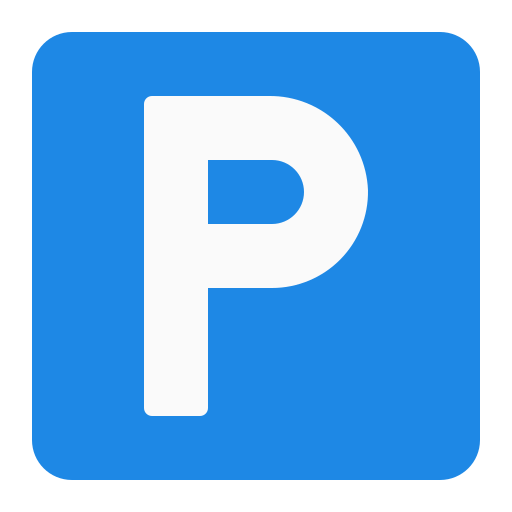
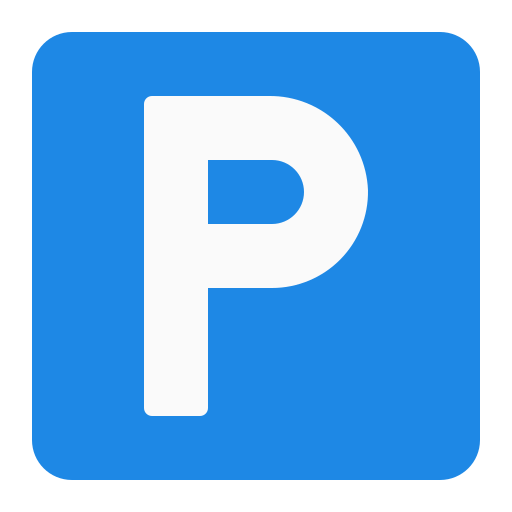
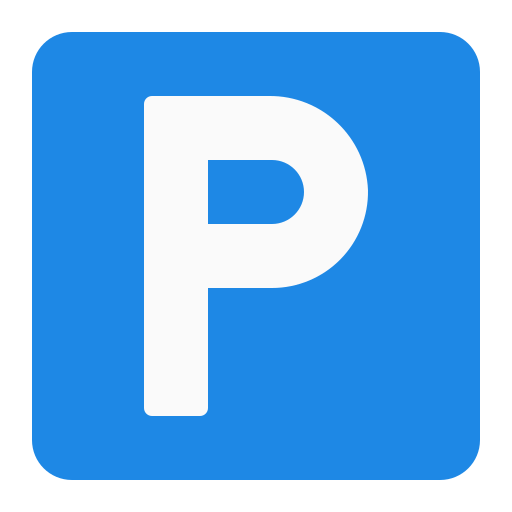
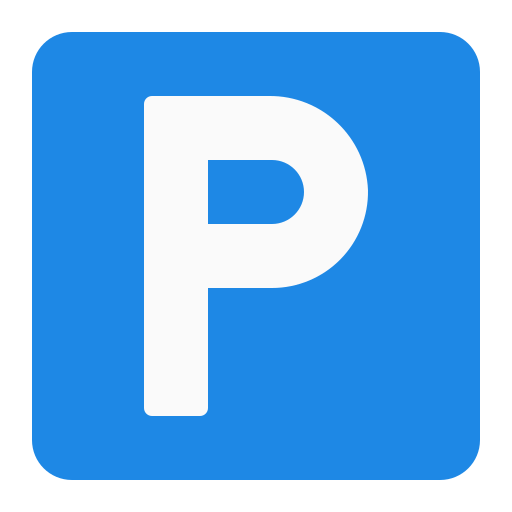
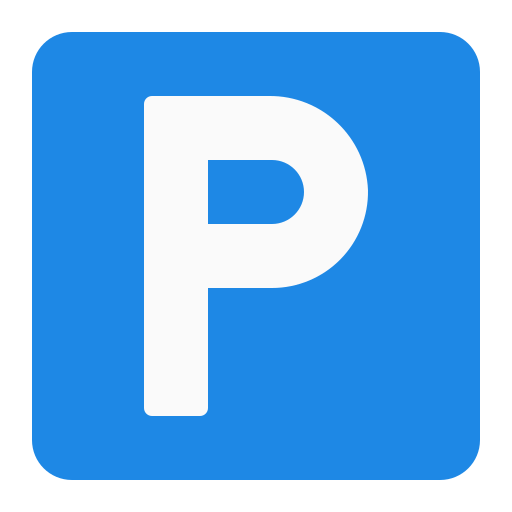
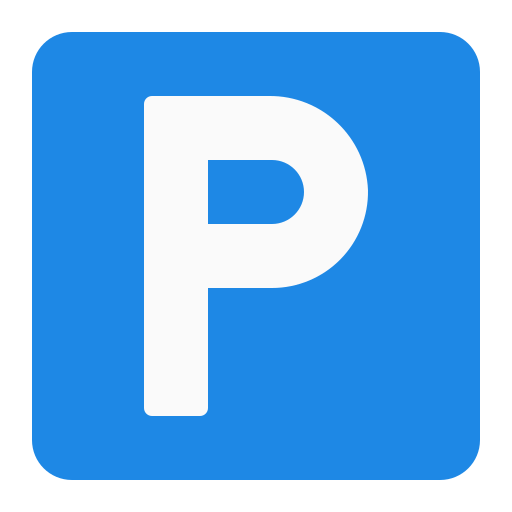
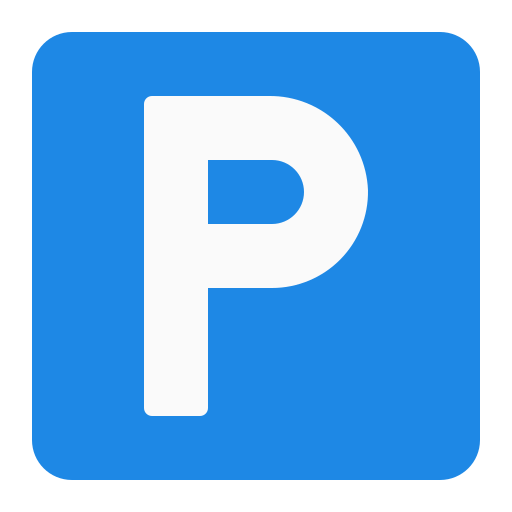
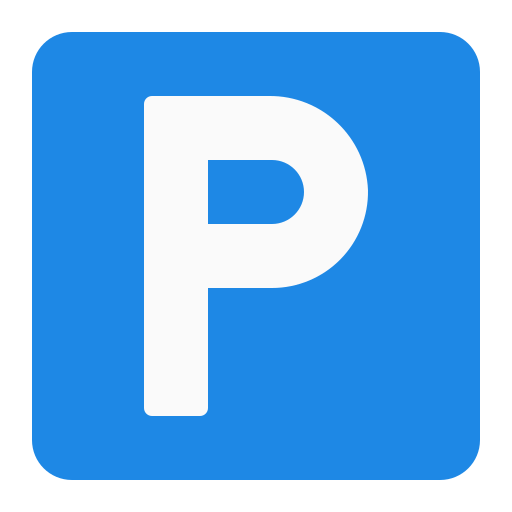
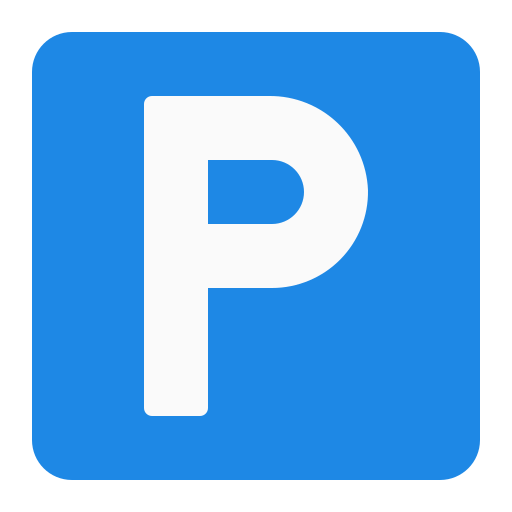
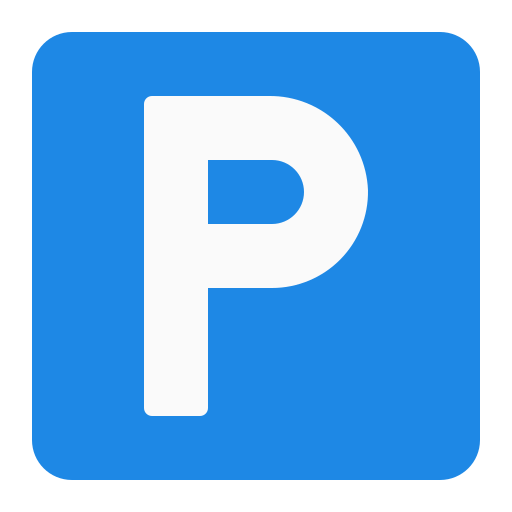
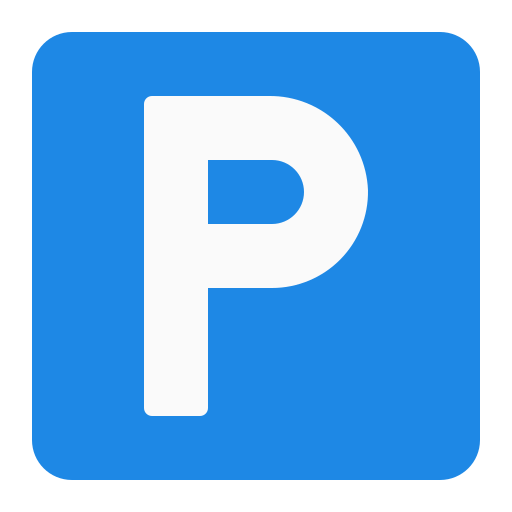
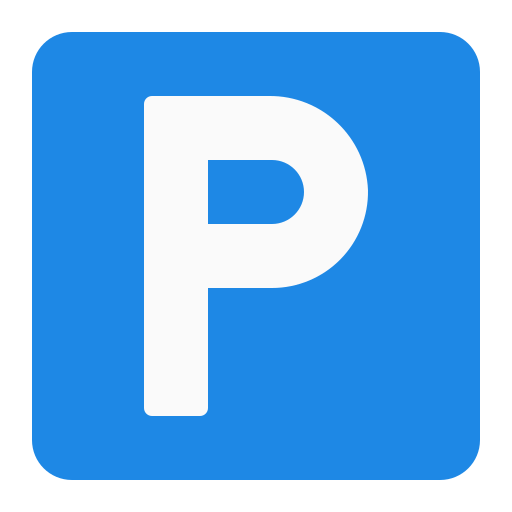
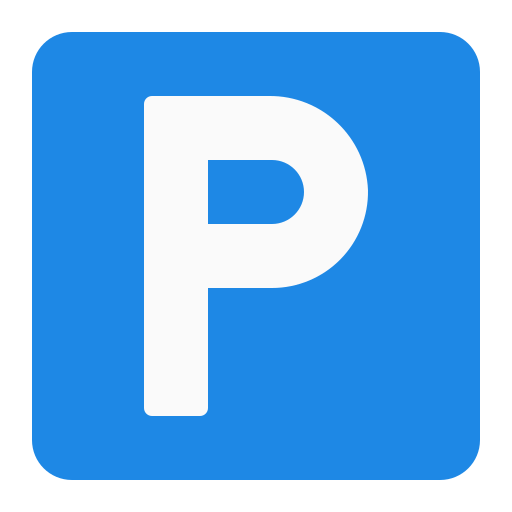
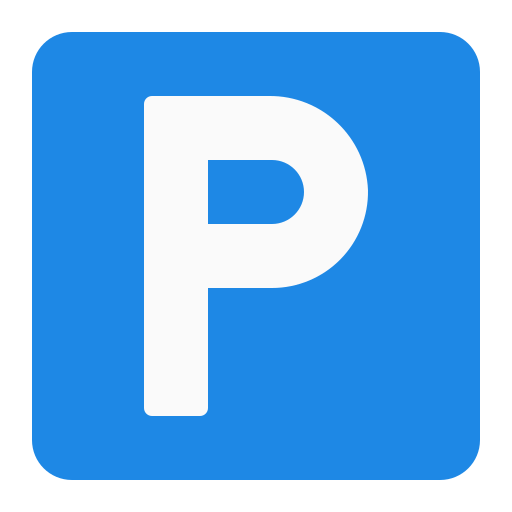
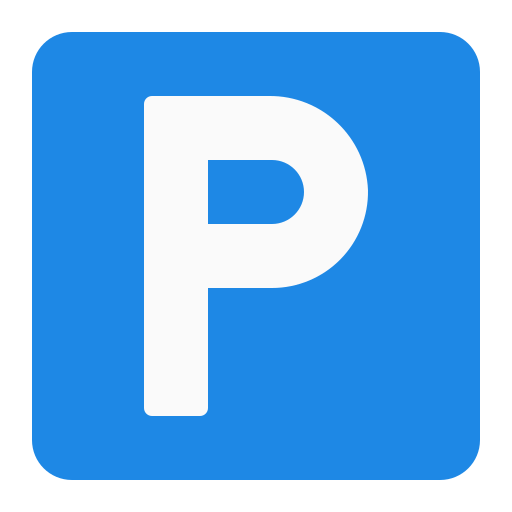
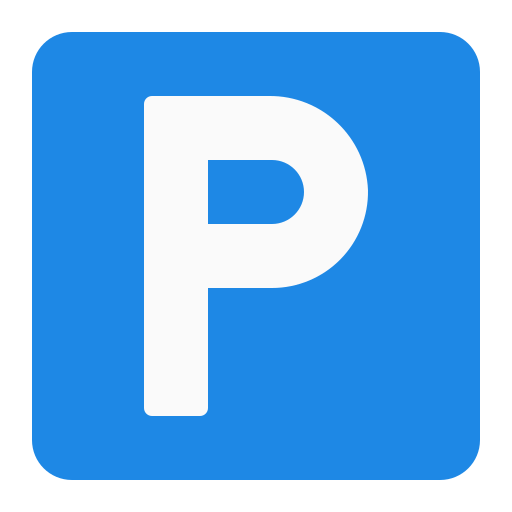
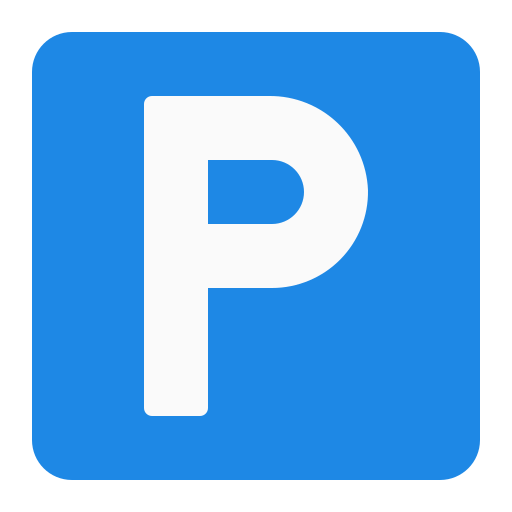
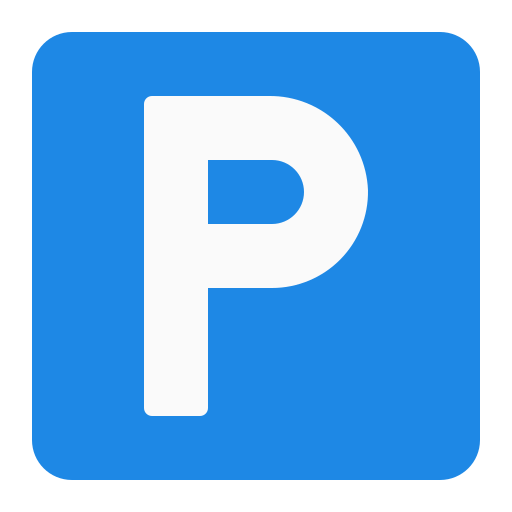
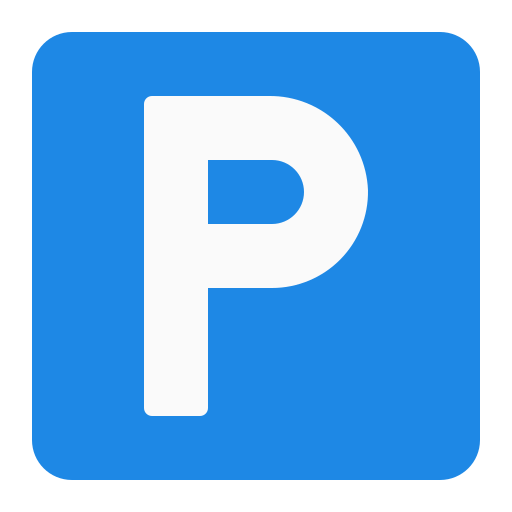
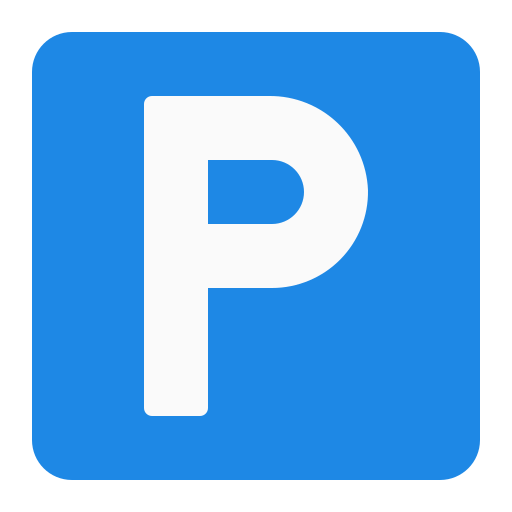
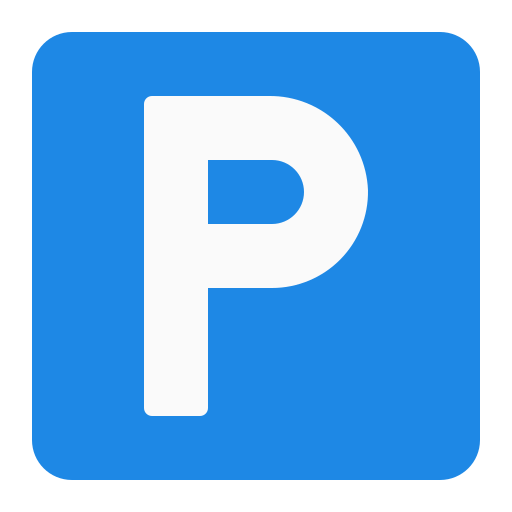
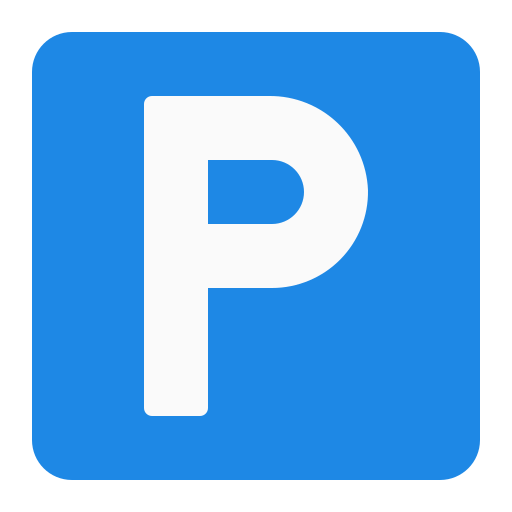
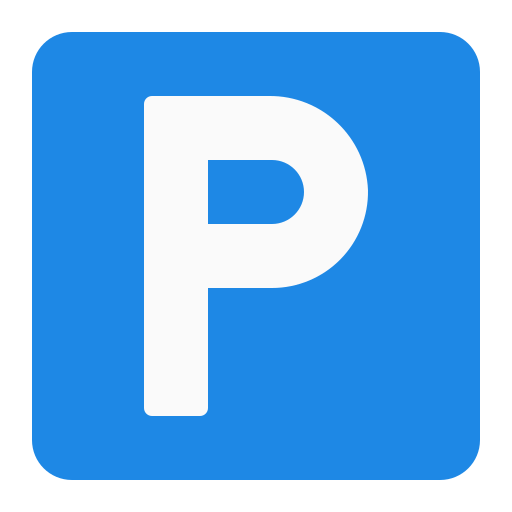
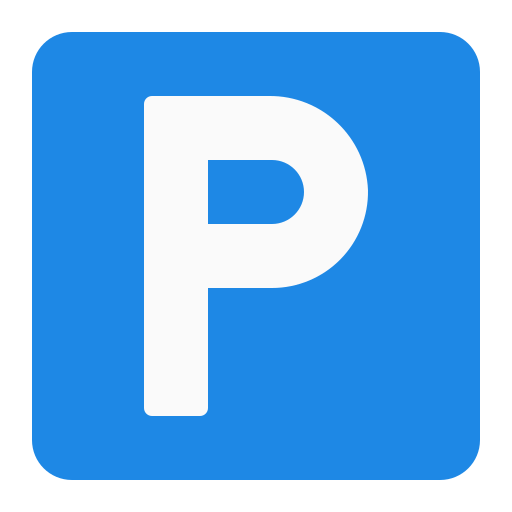
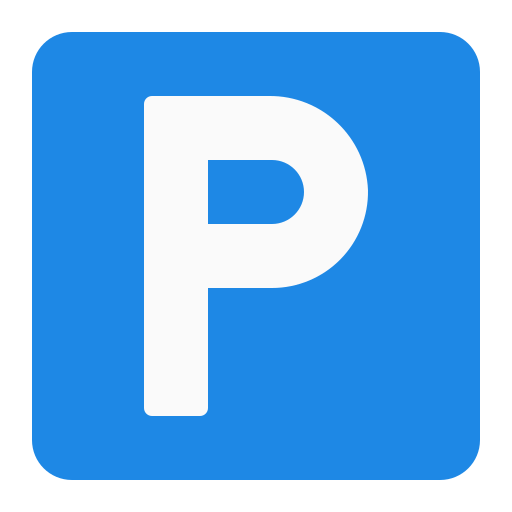
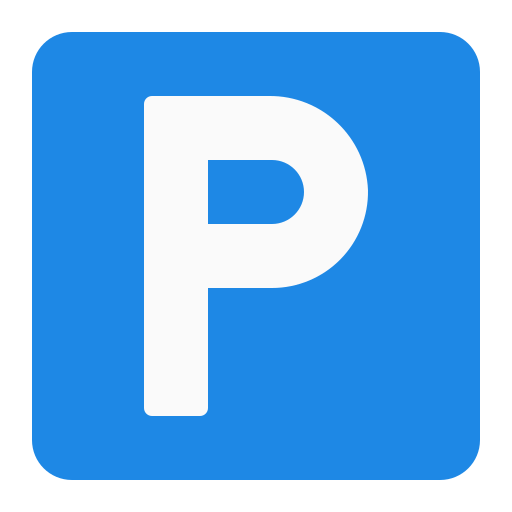
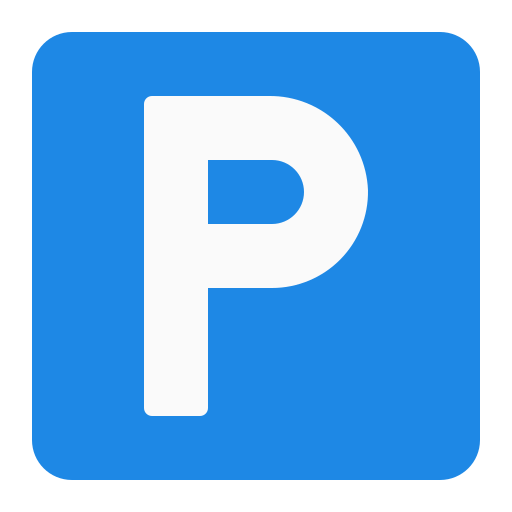
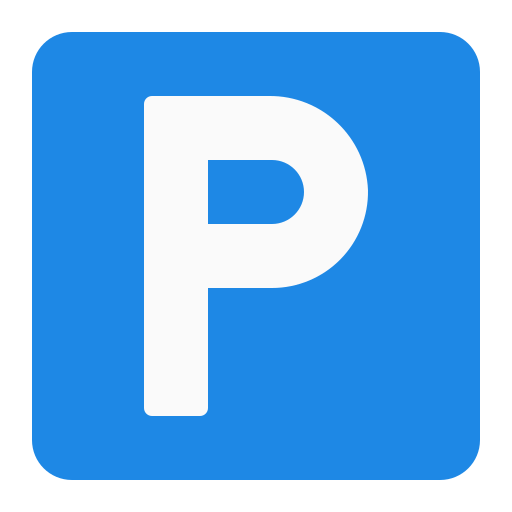
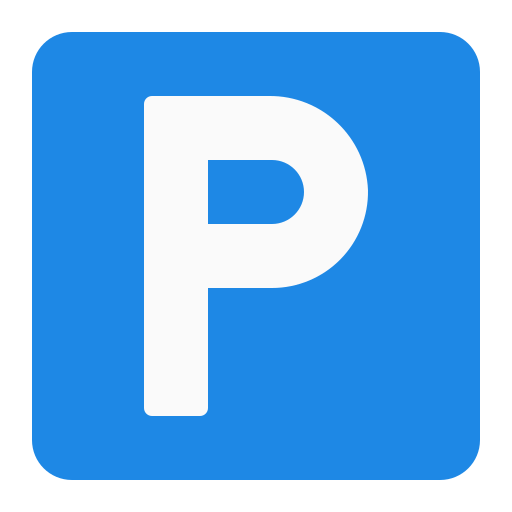
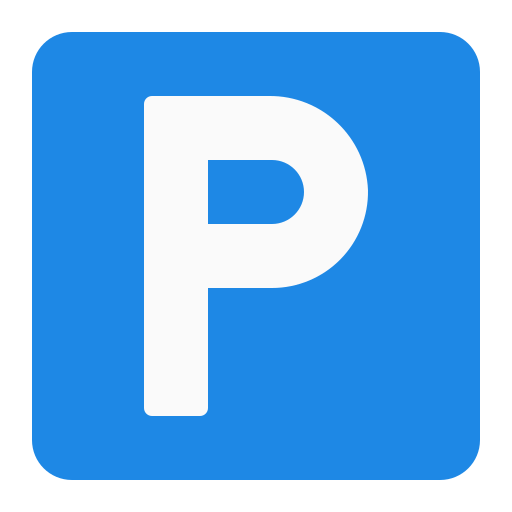
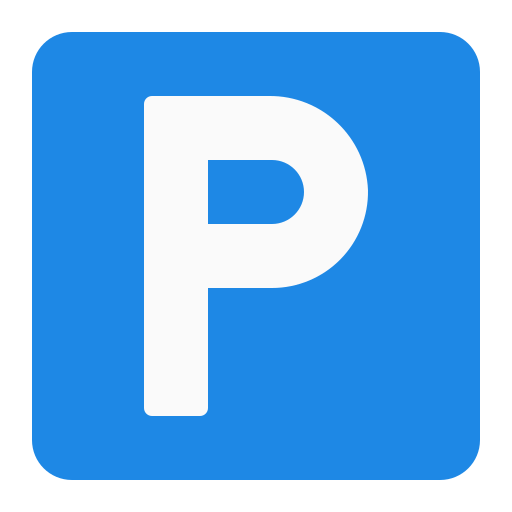
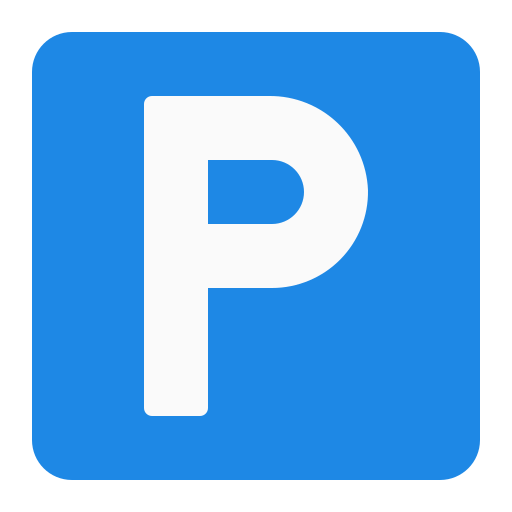
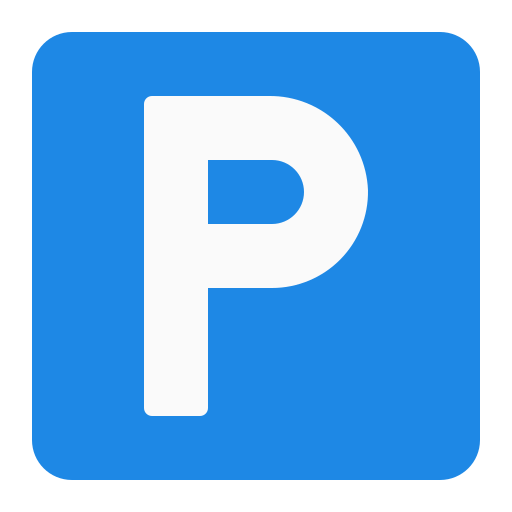
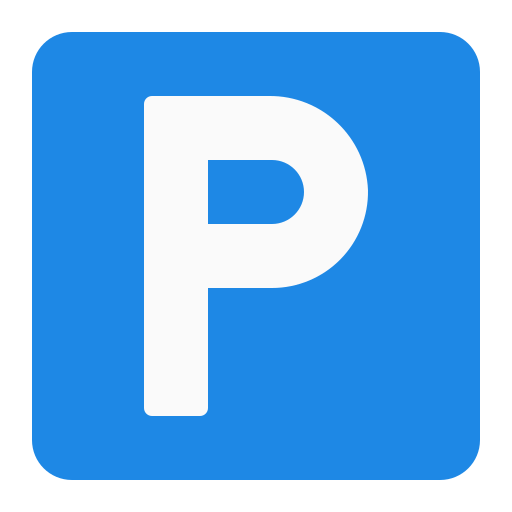
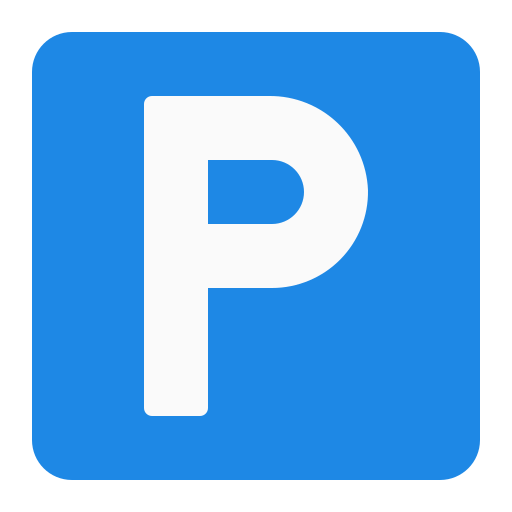
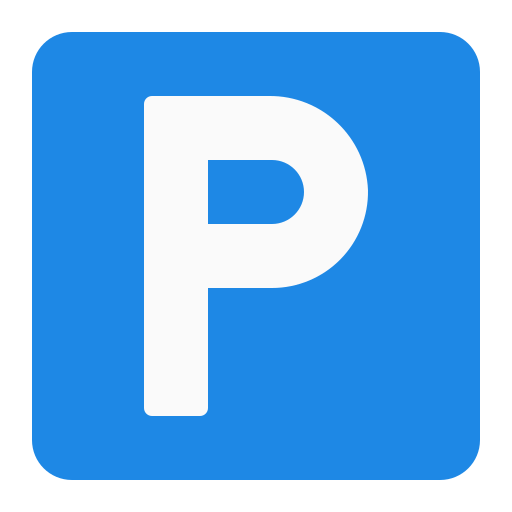
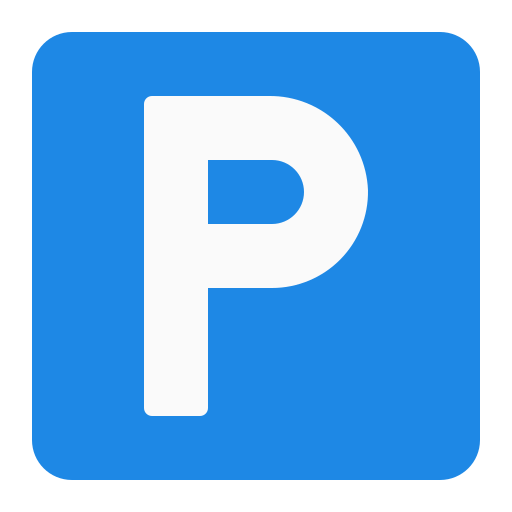
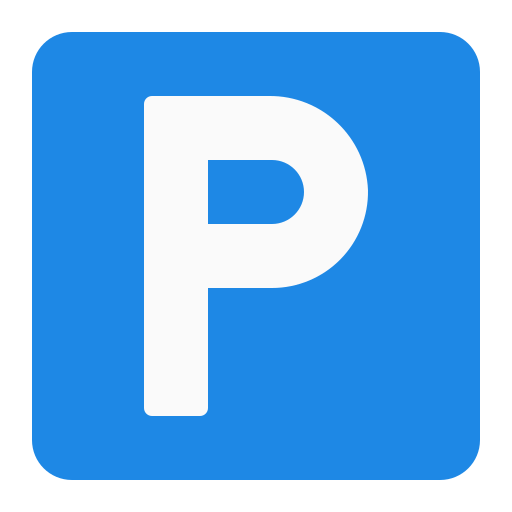
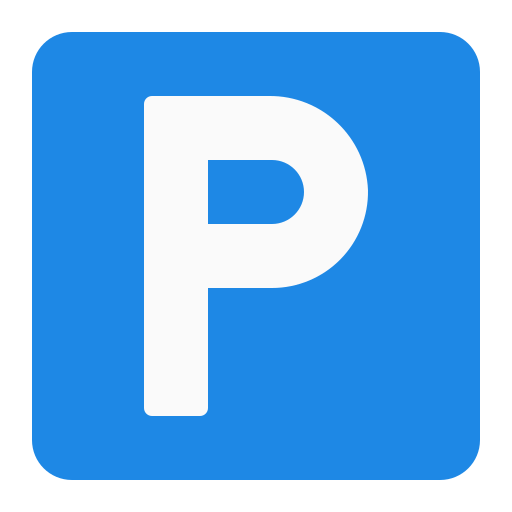
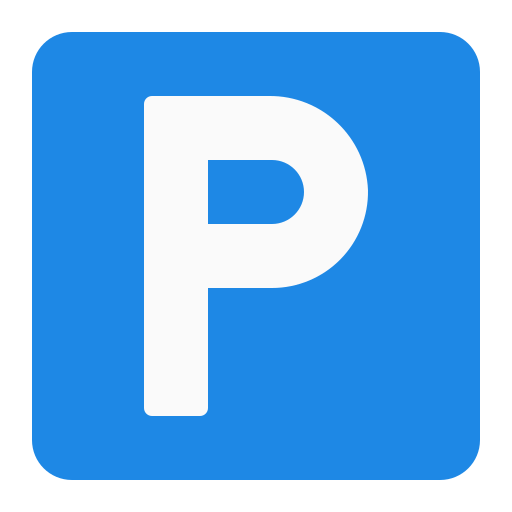
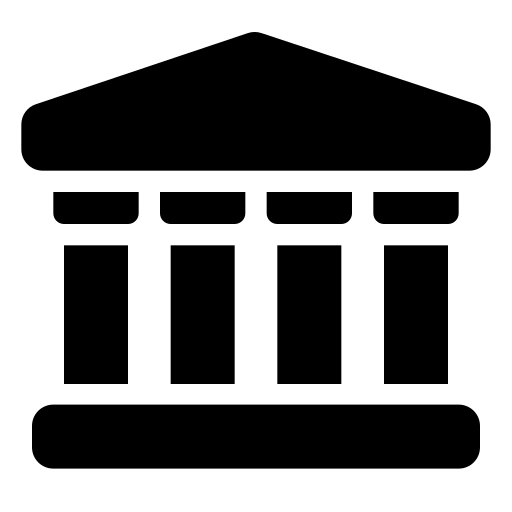
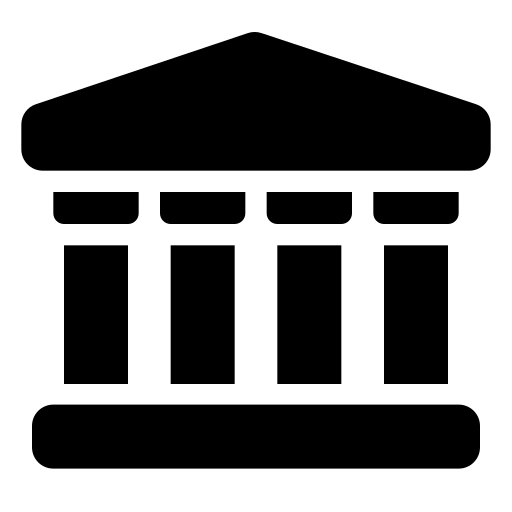
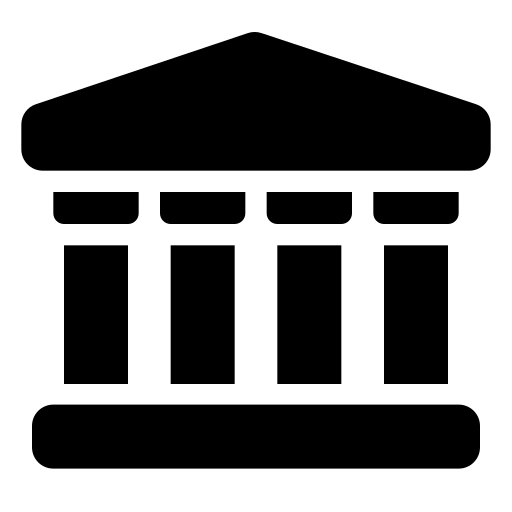
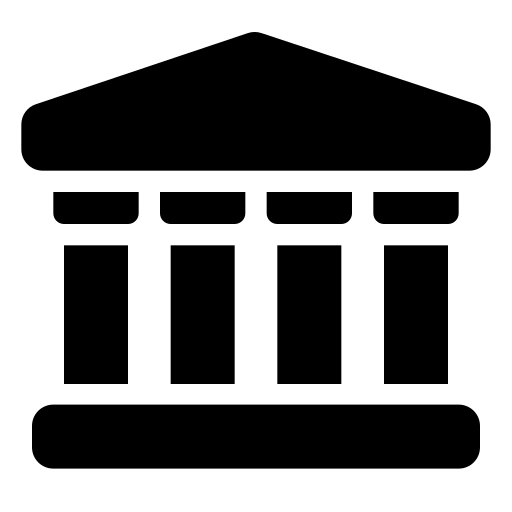
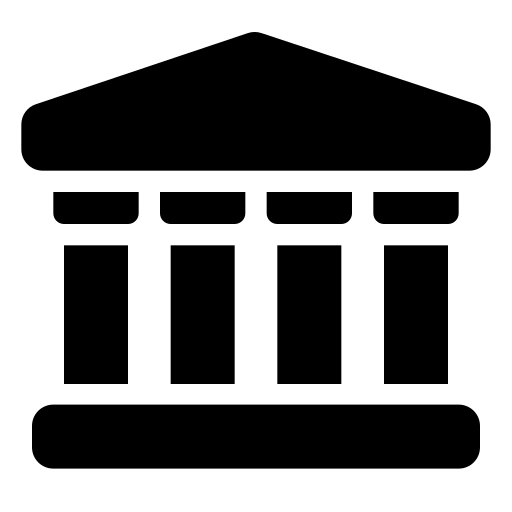
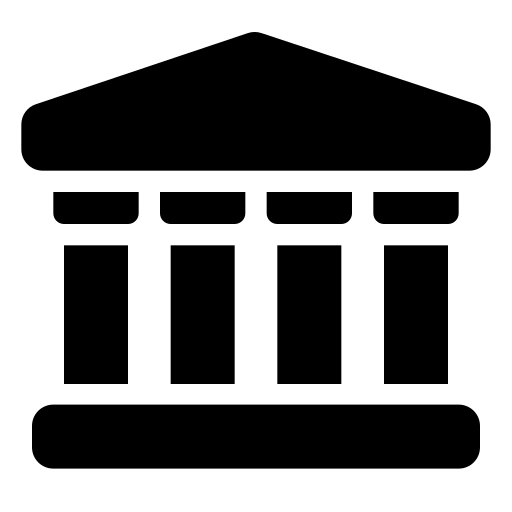
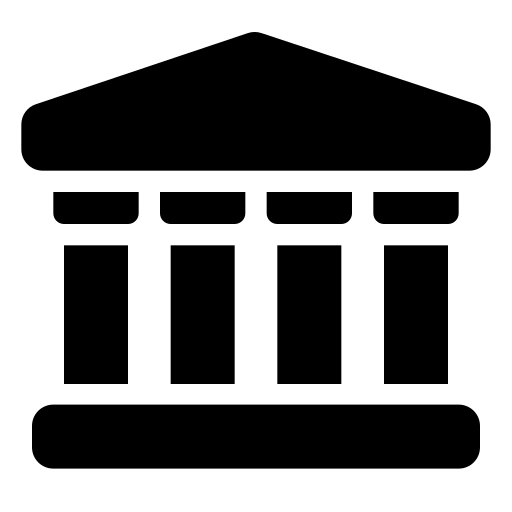
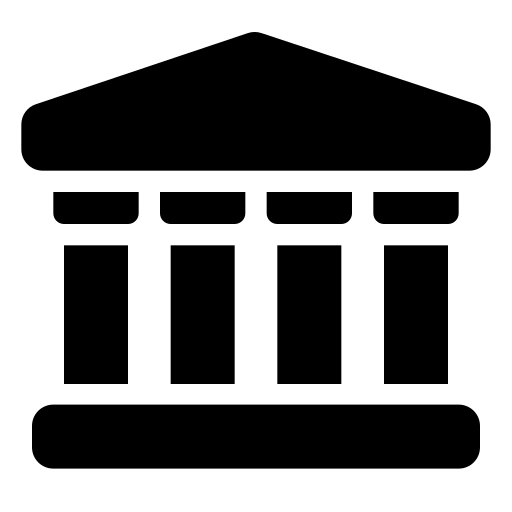
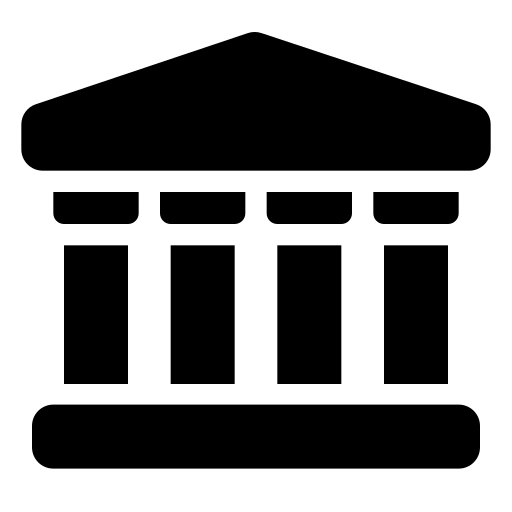
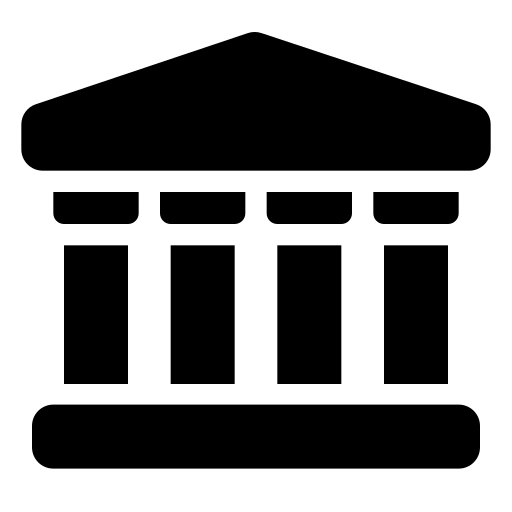
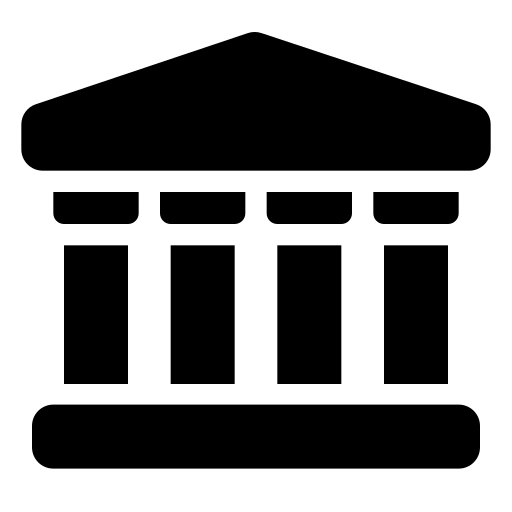
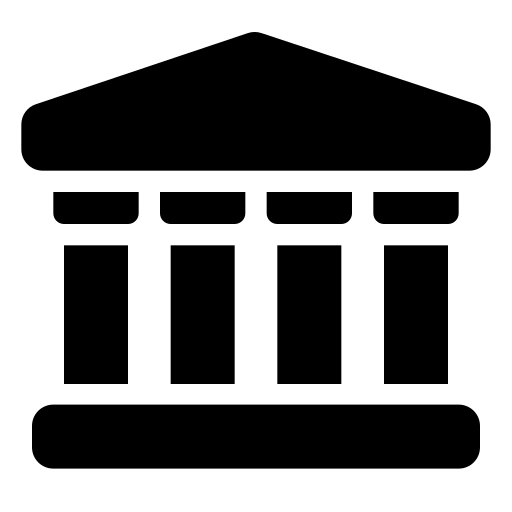
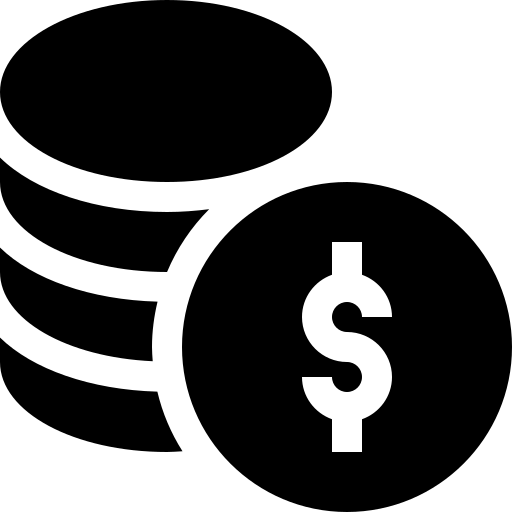
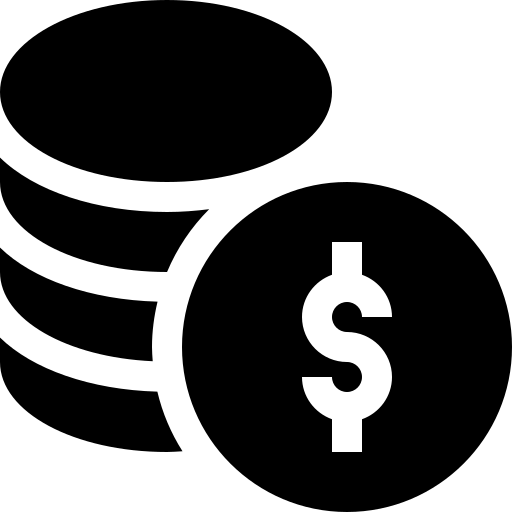
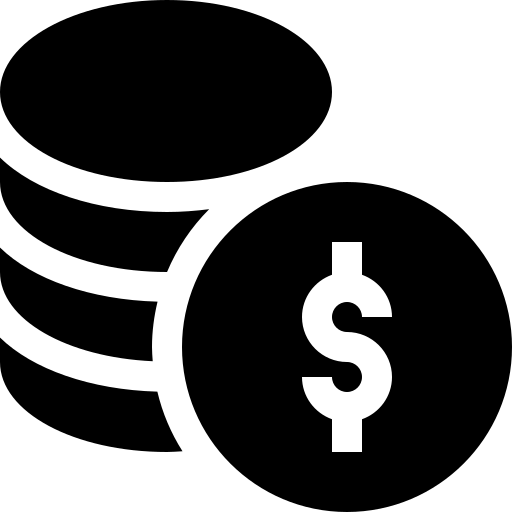
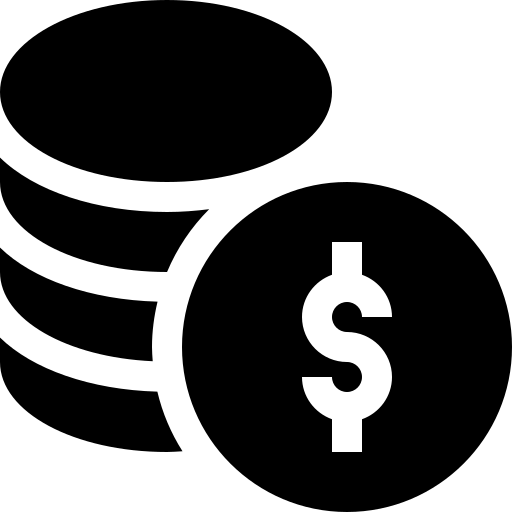
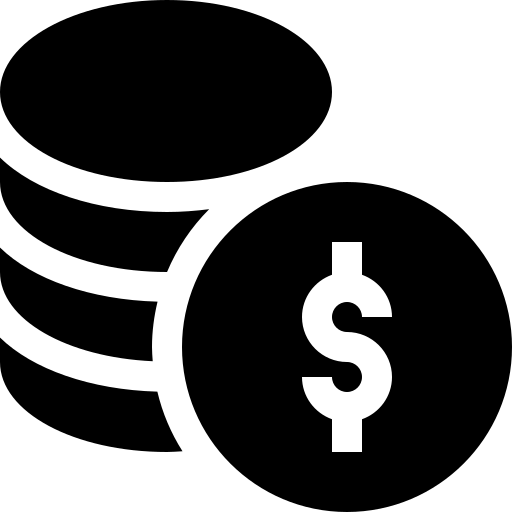
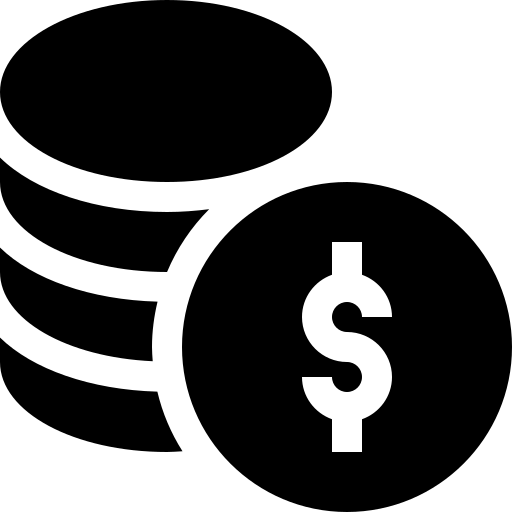
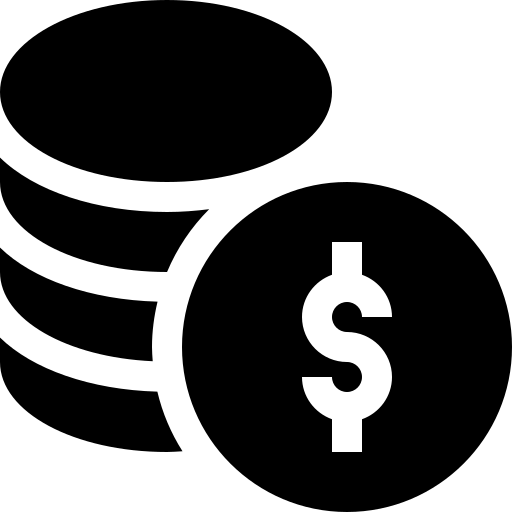
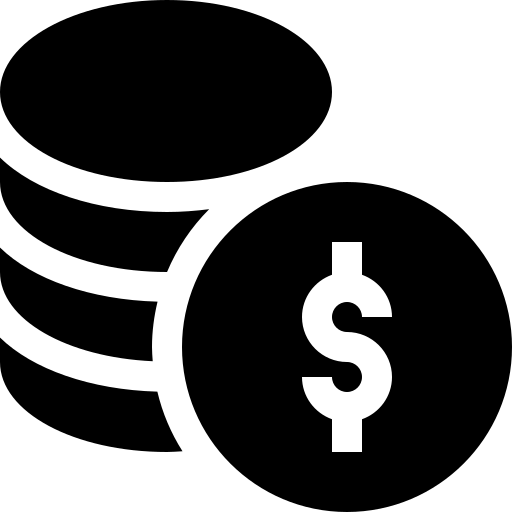
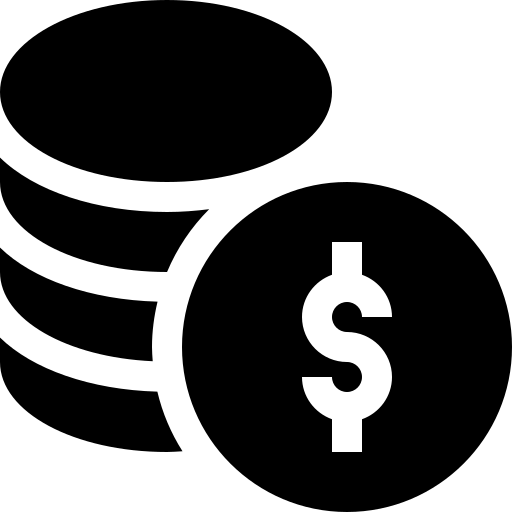
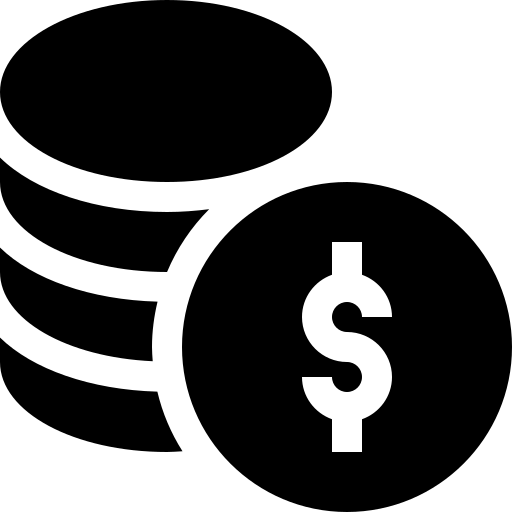
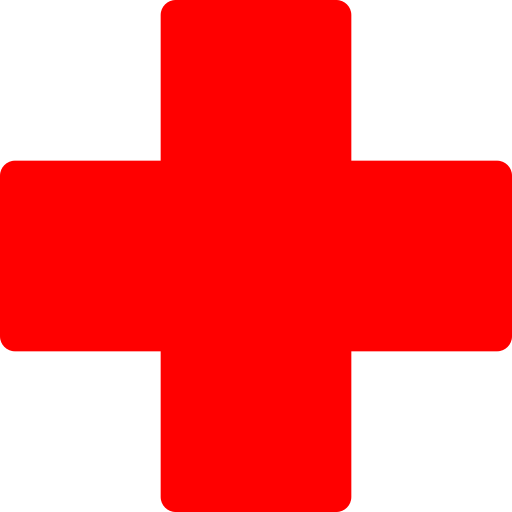
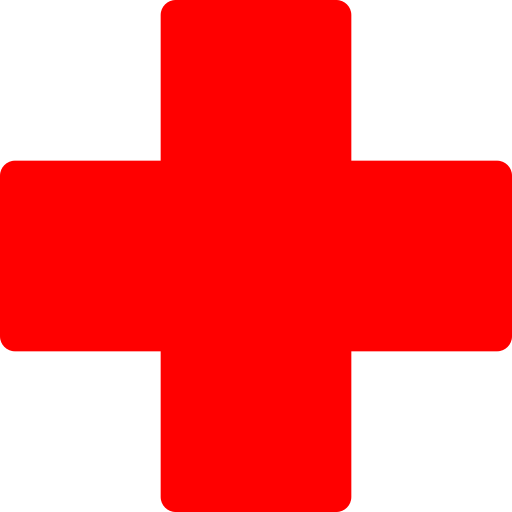
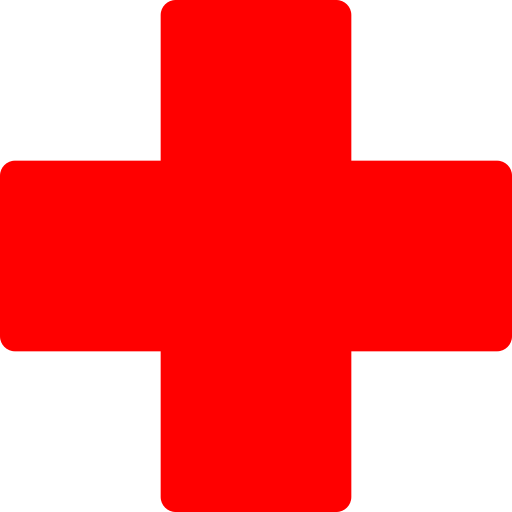
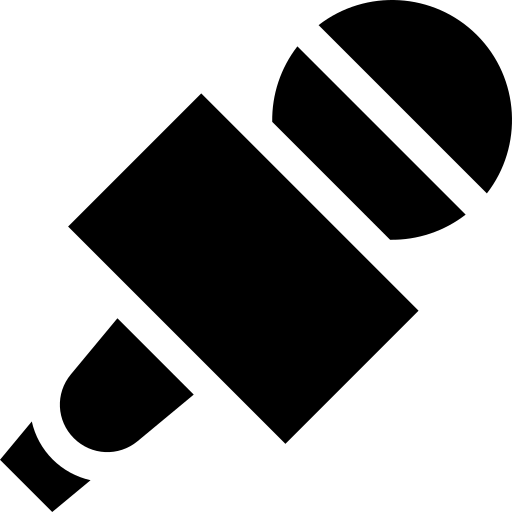
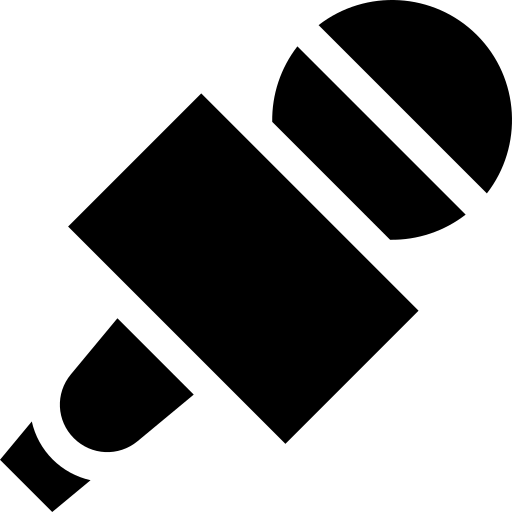
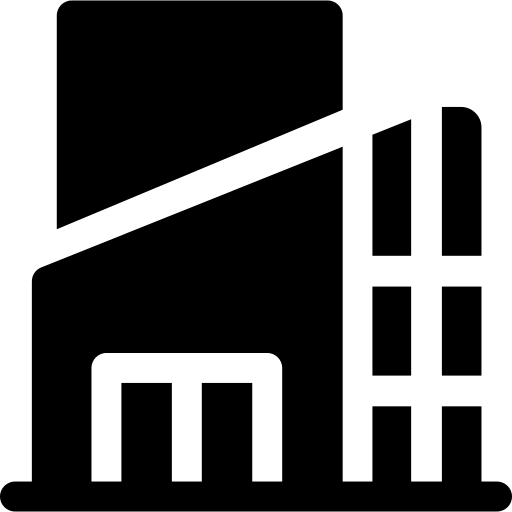
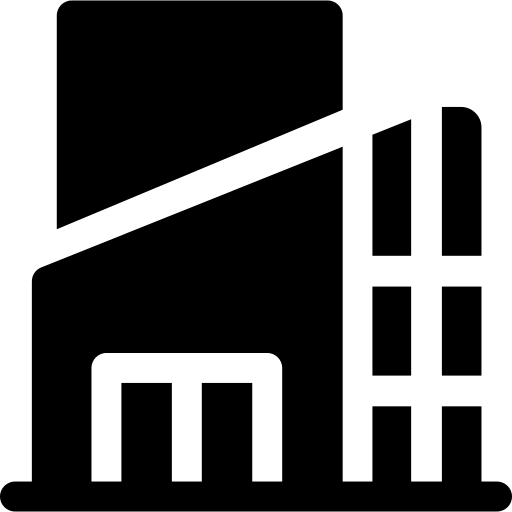
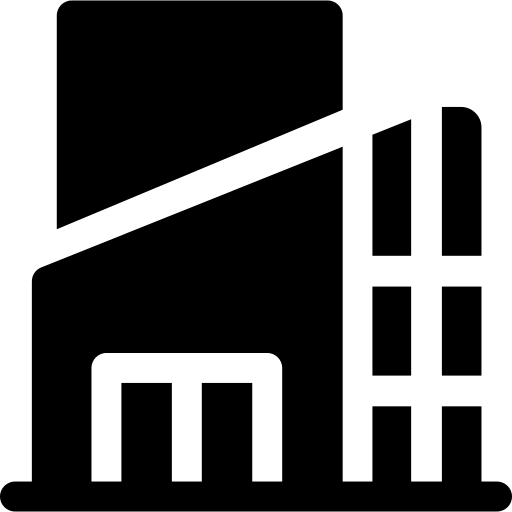

In [22]:
# map 생성
m = folium.Map(location=[36.627797, 127.511943], zoom_start=14)

# 기본 배경지도를 항상 표시하도록 설정 및 기본 도로망 추가
folium.TileLayer('openstreetmap', overlay=False).add_to(m)
grid_geojson = tot_roadsystem['geometry'].to_json()
grid_layer = folium.GeoJson(
    grid_geojson,
    name="도로망",
    style_function=lambda feature: {
        'fillColor': 'none',
        'color': 'gray',
        'weight': 5
    })
grid_layer.add_to(m)

# 레이어 추가. 체크해제(비활성화)된 상태로 표시되도록 함
m_2020 = folium.FeatureGroup(name="2020년", overlay=False)
m_2021 = folium.FeatureGroup(name="2021년", overlay=False)
m_2022 = folium.FeatureGroup(name="2022년", overlay=False)

year_lst = ['2020', '2021', '2022']
layers_lst = [m_2020, m_2021, m_2022]
layers_dic = {}
for year, layer in zip(year_lst, layers_lst):
    layers_dic[year] = layer

# 비 MZ세대 유동인구 정규화
filtered_floating_population_totgen_re = filtered_floating_population_totgen.copy()
max_val = filtered_floating_population_totgen_re['N_MZ'].max()
filtered_floating_population_totgen_re['N_MZ'] = filtered_floating_population_totgen_re['N_MZ'].apply(lambda x : round((x/max_val)*100,2))
# 연도별 데이터프레임을 만들고 레이어 추가
for year in year_lst:  # 2020부터 2022까지의 연도
    filtered_floating_population_totgen_year = filtered_floating_population_totgen[filtered_floating_population_totgen['연도'] == year].copy()
    # 'geometry' 열의 값을 위치 정보로 사용하여 N_MZ세대 유동량 HeatMap 생성
    heat_data = [[point.centroid.xy[1][0], point.centroid.xy[0][0], floating] for point, floating in zip(filtered_floating_population_totgen_year['geometry'], filtered_floating_population_totgen_year['N_MZ'])]
    HeatMap(heat_data, max_opacity=0.6, radius=25).add_to(layers_dic[year])
    
for layer_instance in layers_dic.values():
    layer_instance.add_to(m)

# 면적으로 radius(반지름)을 계산하는 함수 정의
import math
def find_radius_from_area(area):
    radius = math.sqrt(area / math.pi)
    return radius

# 시장 위치 매핑 및 find_radius_from_area 함수로 시장 면적만큼 radius 설정
m_market = folium.FeatureGroup(name="시장", overlay=True)
for _, row in filtered_points_market.iterrows() :
    popup_text = f"{row['market_nm']} - {row['addr']}"
    folium.Circle(location=(row['lat'], row['lon']), radius=find_radius_from_area(row['area']), color='red', weight = 1,
            fill='red', name="시장").add_to(m_market).add_child(folium.Popup(popup_text, max_width=200))
m_market.add_to(m)

# 주차장 위치 매핑
m_parking = folium.FeatureGroup(name="주차장", overlay=True)
for _, row in filtered_points_parking.iterrows() :
    popup_text = f"{row['carpark_nm']} - {row['slots']}대"
    folium.Marker(location=(row['lat'], row['lon']),
    icon = folium.CustomIcon(icon_image='icon/주차장.png', icon_size=(20, 20))).add_to(m_parking).add_child(folium.Popup(popup_text, max_width=200))
m_parking.add_to(m)

# 공원 위치 매핑
m_park = folium.FeatureGroup(name="공원", overlay=True)
for _, row in filtered_points_park.iterrows() :
    popup_text = f"{row['park_nm']}({row['park_gbn']})"
    folium.Circle(location=(row['lat'], row['lon']), radius=50, color='green', weight = 1,
            fill='red', name="공원").add_to(m_park).add_child(folium.Popup(popup_text, max_width=200))
m_park.add_to(m)

# # 가로수 위치 매핑
# m_tree = folium.FeatureGroup(name="가로수", overlay=True)
# for _, row in filtered_points_tree.iterrows() :
#     folium.Marker(location=(row['lat'], row['lon']),
#     icon = folium.CustomIcon(icon_image='icon/가로수.png', icon_size=(20, 20))).add_to(m_tree)
# m_tree.add_to(m)

# 공공기관 매핑
for public_name in filtered_points_public['inst_gbn'].unique():
    m_public = folium.FeatureGroup(name=f"{public_name}", overlay=True)
    subset = filtered_points_public[filtered_points_public['inst_gbn'] == public_name]
    for _, row in subset.iterrows() :
        popup_text = f"{row['inst_nm']}({row['inst_gbn']})"
        folium.Marker(location=(row['lat'], row['lon']),
        icon = folium.CustomIcon(icon_image=f"icon/{public_name}.png", icon_size=(20, 20))).add_to(m_public).add_child(folium.Popup(popup_text, max_width=200))
    else:
        m_public.add_to(m)
# LayerControl을 사용하여 연도 선택
folium.LayerControl(collapsed=False).add_to(m)

# 지도 출력
m